In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet201,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-densenet201-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet201(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 503s 55ms/step - loss: 0.8804 - acc: 0.7557 - val_loss: 8.6842 - val_acc: 0.2979
Epoch 2/100
9112/9112 [==============================] - 401s 44ms/step - loss: 0.5224 - acc: 0.8581 - val_loss: 1.2443 - val_acc: 0.6006
Epoch 3/100
9112/9112 [==============================] - 333s 37ms/step - loss: 0.0101 - acc: 0.9975 - val_loss: 0.2886 - val_acc: 0.9453
Epoch 67/100
9112/9112 [==============================] - 330s 36ms/step - loss: 0.0086 - acc: 0.9981 - val_loss: 0.3114 - val_acc: 0.9453
Epoch 68/100
9112/9112 [==============================] - 331s 36ms/step - loss: 0.0063 - acc: 0.9982 - val_loss: 0.2184 - val_acc: 0.9609
Epoch 69/100
9112/9112 [==============================] - 338s 37ms/step - loss: 0.0140 - acc: 0.9955 - val_loss: 0.2995 - val_acc: 0.9609
Epoch 70/100
9112/9112 [==============================] - 334s 37ms/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.6304 

9120/9120 [==============================] - 360s 39ms/step - loss: 0.0576 - acc: 0.9821 - val_loss: 0.5209 - val_acc: 0.9035
Epoch 31/100
9120/9120 [==============================] - 355s 39ms/step - loss: 0.0333 - acc: 0.9888 - val_loss: 0.2244 - val_acc: 0.9567
Epoch 32/100
9120/9120 [==============================] - 337s 37ms/step - loss: 0.0065 - acc: 0.9979 - val_loss: 0.2412 - val_acc: 0.9626
Epoch 58/100
9120/9120 [==============================] - 336s 37ms/step - loss: 0.0190 - acc: 0.9952 - val_loss: 5.0751 - val_acc: 0.4606
Epoch 59/100
9120/9120 [==============================] - 336s 37ms/step - loss: 0.0322 - acc: 0.9907 - val_loss: 1.0098 - val_acc: 0.7648
Epoch 60/100
9120/9120 [==============================] - 333s 37ms/step - loss: 0.0094 - acc: 0.9970 - val_loss: 2.6878 - val_acc: 0.6742
Epoch 61/100
9120/9120 [==============================] - 332s 36ms/step - loss: 0.0171 - acc: 0.9945 - val_loss: 0.2757 - val_acc: 0.9439
Epoch 62/100
9120/9120 [================

9130/9130 [==============================] - 168s 18ms/step - loss: 0.0118 - acc: 0.9966 - val_loss: 0.5865 - val_acc: 0.9085
Epoch 59/100
9130/9130 [==============================] - 167s 18ms/step - loss: 0.0152 - acc: 0.9954 - val_loss: 1.7210 - val_acc: 0.7604
Epoch 60/100
9130/9130 [==============================] - 168s 18ms/step - loss: 0.0222 - acc: 0.9924 - val_loss: 1.1558 - val_acc: 0.8499
Epoch 61/100
9130/9130 [==============================] - 162s 18ms/step - loss: 0.0139 - acc: 0.9963 - val_loss: 0.4028 - val_acc: 0.9314
Epoch 62/100
9130/9130 [==============================] - 163s 18ms/step - loss: 0.0160 - acc: 0.9952 - val_loss: 0.3221 - val_acc: 0.9513
Epoch 63/100
9130/9130 [==============================] - 164s 18ms/step - loss: 0.0159 - acc: 0.9951 - val_loss: 0.3448 - val_acc: 0.9344
Epoch 64/100
9130/9130 [==============================] - 160s 18ms/step - loss: 0.0131 - acc: 0.9958 - val_loss: 0.8957 - val_acc: 0.9056
Epoch 65/100
9130/9130 [================

9132/9132 [==============================] - 169s 18ms/step - loss: 0.0913 - acc: 0.9730 - val_loss: 0.4560 - val_acc: 0.9024
Epoch 17/100
9132/9132 [==============================] - 169s 18ms/step - loss: 0.0857 - acc: 0.9724 - val_loss: 0.4740 - val_acc: 0.8725
Epoch 18/100
9132/9132 [==============================] - 168s 18ms/step - loss: 0.0814 - acc: 0.9743 - val_loss: 0.2939 - val_acc: 0.9323
Epoch 19/100
9132/9132 [==============================] - 168s 18ms/step - loss: 0.0741 - acc: 0.9776 - val_loss: 0.3464 - val_acc: 0.8914
Epoch 20/100
9132/9132 [==============================] - 169s 19ms/step - loss: 0.0863 - acc: 0.9734 - val_loss: 0.3021 - val_acc: 0.9173
Epoch 21/100
9132/9132 [==============================] - 169s 18ms/step - loss: 0.0594 - acc: 0.9825 - val_loss: 0.3912 - val_acc: 0.9153
Epoch 22/100
9132/9132 [==============================] - 169s 19ms/step - loss: 0.0650 - acc: 0.9785 - val_loss: 0.1653 - val_acc: 0.9602
Epoch 23/100
9132/9132 [================

9132/9132 [==============================] - 157s 17ms/step - loss: 0.0189 - acc: 0.9945 - val_loss: 0.5848 - val_acc: 0.8785
Epoch 76/100
9132/9132 [==============================] - 157s 17ms/step - loss: 0.0422 - acc: 0.9877 - val_loss: 0.2109 - val_acc: 0.9641
Epoch 77/100
9132/9132 [==============================] - 157s 17ms/step - loss: 0.0055 - acc: 0.9980 - val_loss: 0.1847 - val_acc: 0.9641
Epoch 78/100
9132/9132 [==============================] - 155s 17ms/step - loss: 0.0069 - acc: 0.9981 - val_loss: 0.2263 - val_acc: 0.9552
Epoch 79/100
9132/9132 [==============================] - 156s 17ms/step - loss: 0.0152 - acc: 0.9957 - val_loss: 0.2846 - val_acc: 0.9552
Epoch 80/100
9132/9132 [==============================] - 158s 17ms/step - loss: 0.0152 - acc: 0.9958 - val_loss: 0.2436 - val_acc: 0.9522
Epoch 81/100
9132/9132 [==============================] - 155s 17ms/step - loss: 0.0118 - acc: 0.9967 - val_loss: 0.2218 - val_acc: 0.9631
Epoch 82/100
9132/9132 [================

In [ ]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9034


In [ ]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

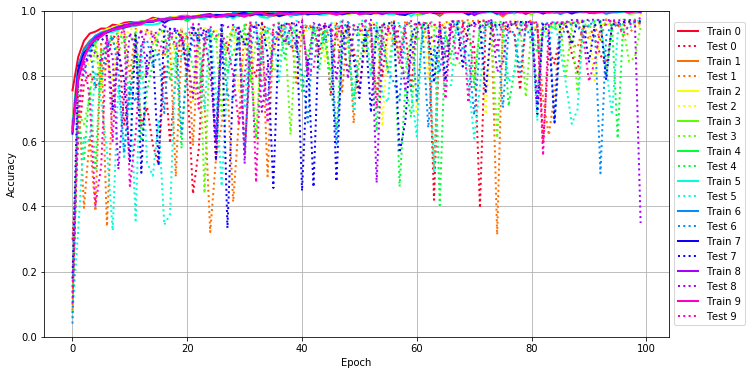

In [ ]:
plot_acc(history)

In [ ]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

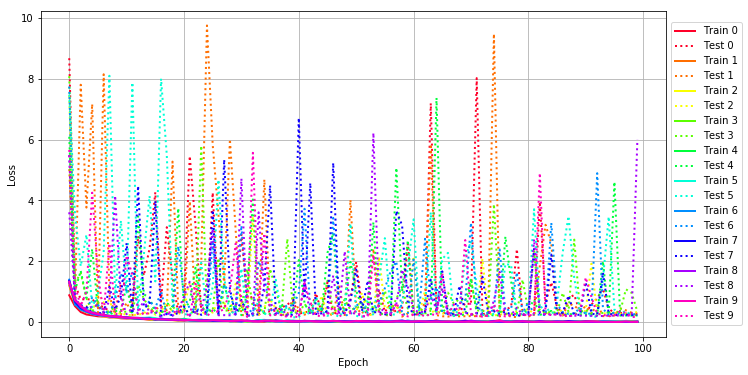

In [ ]:
plot_loss(history)

Plotting the confusion matrix


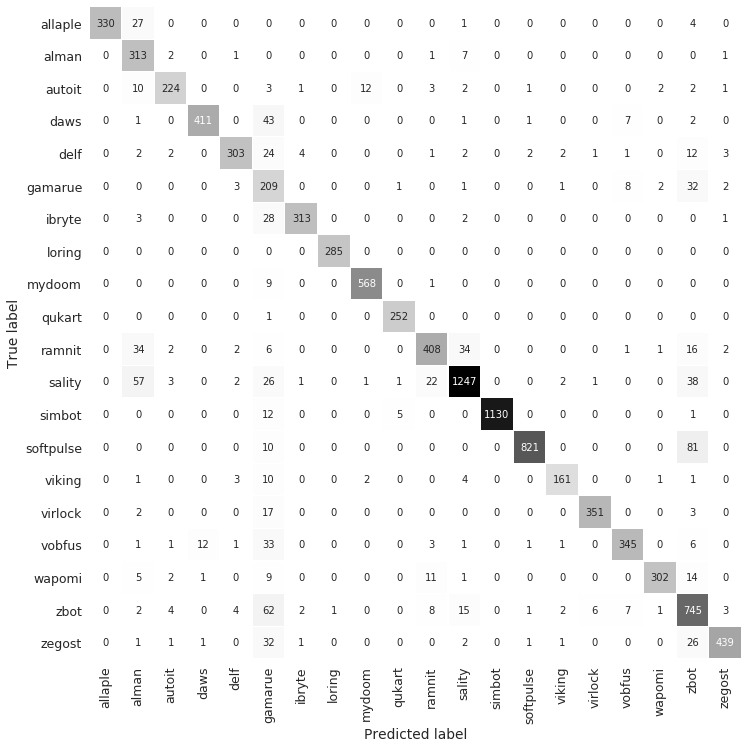

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


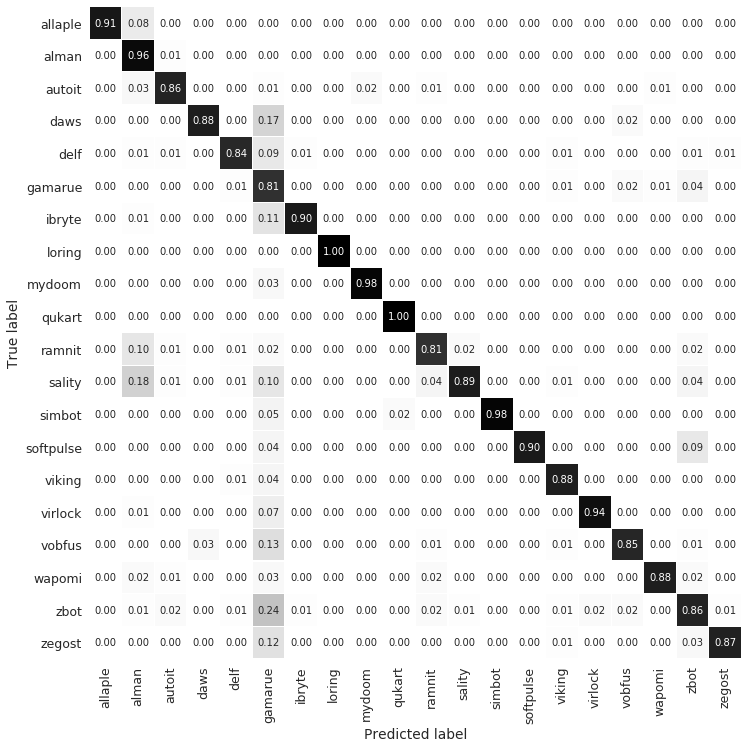

In [ ]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for h in history:
    print(h.history)

{'acc': [0.7557067603683975, 0.8580992098855177, 0.9074846357499643, 0.9297629500084326, 0.9357989465489107, 0.9452370500438981, 0.9447980685334545, 0.956979806900443, 0.9548946445295955, 0.9629060580502277, 0.9652107112547931, 0.9640035118525022, 0.9665276559431162, 0.9696005267778753, 0.9783801580333626, 0.9744293239683933, 0.9746488147497805, 0.9773924495171202, 0.9795873573309921, 0.9838674276727035, 0.9843064091308165, 0.9761852502194908, 0.9845258999122037, 0.9874890254609306, 0.9880377524143986, 0.9845258999122037, 0.9871597893935112, 0.9840869183494293, 0.9913301141352063, 0.9925373134328358, 0.9872695346795435, 0.9847453906935909, 0.9915496050212549, 0.9936347673397717, 0.9960491659350307, 0.9843064091308165, 0.9924275680421423, 0.995171202809482, 0.9922080773654164, 0.9912203687445127, 0.9931957857769974, 0.9971466198419666, 0.9955004389815628, 0.9967076382791923, 0.9906716418957061, 0.9938542581211589, 0.994622475856014, 0.996268656716418, 0.9896839332748024, 0.9960491659350

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

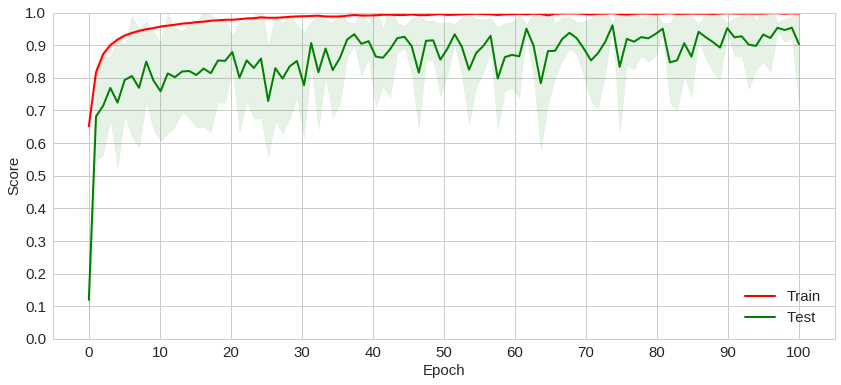

In [ ]:
plot_mean_acc(history)

In [ ]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

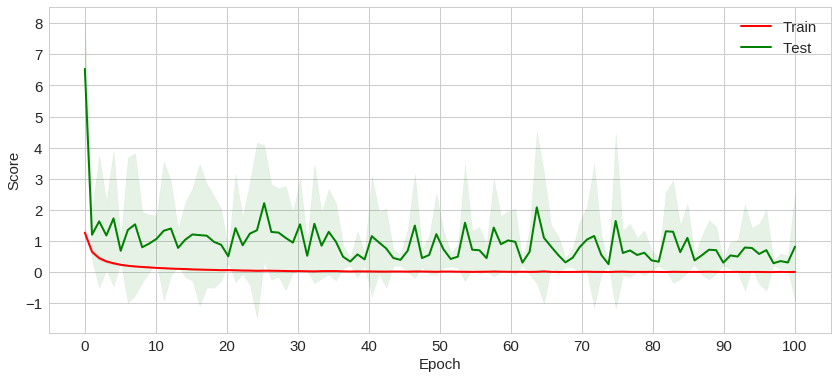

In [ ]:
plot_mean_loss(history)

In [2]:
hist = [{'acc': [0.7557067603683975, 0.8580992098855177, 0.9074846357499643, 0.9297629500084326, 0.9357989465489107, 0.9452370500438981, 0.9447980685334545, 0.956979806900443, 0.9548946445295955, 0.9629060580502277, 0.9652107112547931, 0.9640035118525022, 0.9665276559431162, 0.9696005267778753, 0.9783801580333626, 0.9744293239683933, 0.9746488147497805, 0.9773924495171202, 0.9795873573309921, 0.9838674276727035, 0.9843064091308165, 0.9761852502194908, 0.9845258999122037, 0.9874890254609306, 0.9880377524143986, 0.9845258999122037, 0.9871597893935112, 0.9840869183494293, 0.9913301141352063, 0.9925373134328358, 0.9872695346795435, 0.9847453906935909, 0.9915496050212549, 0.9936347673397717, 0.9960491659350307, 0.9843064091308165, 0.9924275680421423, 0.995171202809482, 0.9922080773654164, 0.9912203687445127, 0.9931957857769974, 0.9971466198419666, 0.9955004389815628, 0.9967076382791923, 0.9906716418957061, 0.9938542581211589, 0.994622475856014, 0.996268656716418, 0.9896839332748024, 0.9960491659350307, 0.9934152765583846, 0.9938542581211589, 0.9986830553116769, 0.9952809483048369, 0.9981343283582089, 0.9983538191395961, 0.9915496050212549, 0.9886962247585601, 0.997585601404741, 0.9970368744512731, 0.9989025460930641, 0.9995610184372257, 0.9990122914837577, 0.9956101843722563, 0.9841966637401229, 0.9974758560140474, 0.9981343283582089, 0.9982440737489026, 0.9955004389815628, 0.9970368744512731, 0.9989025460930641, 0.9968173837745472, 0.9944029850746269, 0.9989025460930641, 0.9983538191395961, 0.997585601404741, 0.992866549709578, 0.9964881474978051, 0.9960491659350307, 0.9986830553116769, 0.9991220368744512, 0.9992317822651449, 0.9990122914837577, 0.9964881476024664, 0.9930860404909652, 0.9967076382791923, 0.9985733099209834, 0.9951712029141434, 0.996268656716418, 0.9993415276558385, 0.9989025460930641, 0.9972563652326603, 0.9942932396839332, 0.9973661106233538, 0.99571992976295, 0.9987928007023705, 0.99571992976295, 0.9996707638279192, 0.9997805092186128, 0.9996707638279192], 'val_loss': [8.684170497290324, 1.2443186912423698, 0.7467998652026613, 0.7460024715910567, 0.7469153311772136, 0.5688434240487368, 0.4889716639663675, 0.36097768423314847, 0.30038307158577027, 1.2629558002620342, 1.2704541370740117, 0.4722343572950649, 2.831588604121748, 1.5284161280553121, 2.419423814196307, 4.27089084779891, 0.6729799609142582, 3.121686892812022, 1.4925206123589305, 0.2598135069150942, 0.7777818719387168, 5.462416714187839, 3.1967412178182713, 0.40427156510486384, 0.42502844928139893, 4.259016457537655, 0.4630229080080426, 0.5717163122433817, 0.317592886565464, 0.3608381209288716, 2.8808539192377793, 0.7794605380026951, 0.82859054325003, 0.24102729583821825, 0.35113128571803287, 0.3449025386982818, 0.3783499542981872, 0.4615634303279492, 0.5816106626255708, 0.6796439265433722, 0.27113209777317415, 0.3207241688120641, 0.33866260166215056, 0.9471070150766927, 0.2991761989644317, 1.2984070363849582, 0.2166428635119768, 0.4371049438650516, 0.3133426784644664, 0.7415386768457224, 1.9748562315039528, 0.5113001710078446, 0.24492912262202982, 0.27008540461856967, 1.0641207767555159, 0.33044601290450615, 0.5858493069047199, 0.3009851079689554, 0.4159225664270254, 2.5867225431140923, 0.2862517793355992, 0.21691572232442624, 0.3274150884472258, 7.199772251984541, 0.3335192295872318, 0.2886016074359503, 0.3113609348718014, 0.21836521198074665, 0.2994701112383851, 0.6304209171466333, 0.5794728357101357, 8.029526591242817, 0.2575916017127198, 0.2849533047399029, 0.3851540022304878, 0.34014954841356015, 0.39062009752797167, 0.5039912766276871, 2.3994528348116555, 0.24588382933676067, 0.2862659570075472, 0.2364716604735282, 3.955928594924334, 0.6271243293523985, 1.3062571368591307, 0.4891555674508661, 0.27916314391826624, 0.7900593659926374, 0.8907773404435426, 0.32234692079091554, 0.3048202807507545, 0.5743225450180489, 0.7752039602627083, 1.0954484261328958, 0.43880467786103194, 0.29336342952835315, 0.3050470465262798, 0.2719774759645155, 0.3033178191775918, 0.27267450902635737], 'loss': [0.8804164153112457, 0.52244211178636, 0.3291076334737915, 0.24700759287148427, 0.21787890505055466, 0.18744794861515746, 0.1789275859404908, 0.14981536275467608, 0.15144075494655346, 0.12108261014569528, 0.11429590305282397, 0.11770494114623926, 0.10086385719232831, 0.0945786974479504, 0.07192255590680113, 0.07652338665294361, 0.07739728438497061, 0.06523201380540716, 0.06425059931798363, 0.04825350940438058, 0.04664473486283371, 0.07541751391945294, 0.05131363550773834, 0.0404854949785125, 0.03652045248085314, 0.051174666529461656, 0.0381485493935966, 0.04905760190629542, 0.026514260783108586, 0.023447284552890007, 0.04011449809617224, 0.04351223802088316, 0.02724520163922313, 0.019413956959833164, 0.012102813042226402, 0.05271461981541765, 0.023888783049277055, 0.017822599582881765, 0.02495236868225866, 0.030035432376864075, 0.02082203069125438, 0.010370037516774403, 0.016004116165424007, 0.011005053089486516, 0.03159194806449194, 0.02164482792069434, 0.021214389569669104, 0.013853141536181394, 0.03183993229149093, 0.011893188468607522, 0.020629684125363833, 0.02440289010648215, 0.005187418341727087, 0.01713364617983382, 0.00768633611171427, 0.004687865353754813, 0.027747161595665804, 0.036147810299574944, 0.00931132681312356, 0.008428008688035822, 0.004349032796622233, 0.0027625198889610235, 0.006379132949378026, 0.01770405460303905, 0.052798960490487844, 0.010096100018063265, 0.008633217463431306, 0.006329437456723281, 0.014031283320355494, 0.010882340101638127, 0.004072538218051633, 0.01083099875336282, 0.01665077131075938, 0.005721563306963811, 0.005503279572064223, 0.00796118575088919, 0.023392379844837285, 0.014624679286895433, 0.011745783608511405, 0.004036970717878582, 0.0037137994298391645, 0.0037672875993546885, 0.00231205751772835, 0.012892703639053132, 0.023655835366990063, 0.009384735757634799, 0.005366124014154602, 0.021438936950160286, 0.014410734094799585, 0.0024664587122376173, 0.003432346111997043, 0.008134101753309747, 0.015852618150692905, 0.008200404948459342, 0.013421111928605397, 0.004687559821045186, 0.013333657301965543, 0.0017837833050427987, 0.0012005380511448808, 0.0013623690945853463], 'val_acc': [0.2978515625, 0.6005859375, 0.775390625, 0.8095703125, 0.765625, 0.8486328125, 0.845703125, 0.921875, 0.9150390625, 0.650390625, 0.7451171875, 0.8896484375, 0.6474609375, 0.7041015625, 0.5888671875, 0.529296875, 0.8359375, 0.59375, 0.798828125, 0.9462890625, 0.7802734375, 0.4384765625, 0.5751953125, 0.9013671875, 0.923828125, 0.5390625, 0.9111328125, 0.8779296875, 0.947265625, 0.93359375, 0.572265625, 0.8447265625, 0.7978515625, 0.962890625, 0.9365234375, 0.9326171875, 0.9296875, 0.9189453125, 0.888671875, 0.8828125, 0.953125, 0.9462890625, 0.9521484375, 0.8662109375, 0.9580078125, 0.73828125, 0.9609375, 0.9287109375, 0.9462890625, 0.8818359375, 0.7568359375, 0.9072265625, 0.9599609375, 0.955078125, 0.7998046875, 0.9521484375, 0.89453125, 0.953125, 0.943359375, 0.75390625, 0.9580078125, 0.9638671875, 0.955078125, 0.419921875, 0.95703125, 0.9453125, 0.9453125, 0.9609375, 0.9609375, 0.90625, 0.8896484375, 0.39453125, 0.9560546875, 0.9580078125, 0.9482421875, 0.94921875, 0.939453125, 0.92578125, 0.7568359375, 0.966796875, 0.962890625, 0.962890625, 0.595703125, 0.884765625, 0.837890625, 0.9306640625, 0.962890625, 0.8681640625, 0.810546875, 0.951171875, 0.955078125, 0.9140625, 0.8642578125, 0.8310546875, 0.943359375, 0.9619140625, 0.953125, 0.962890625, 0.9599609375, 0.9609375]},
{'acc': [0.6584375686281366, 0.8300416940446744, 0.8841342990770397, 0.9077243801661691, 0.9213298224345984, 0.9327408384669892, 0.9408602152368807, 0.9463462805392215, 0.9468948869870529, 0.9517226245467643, 0.9584156243142419, 0.9613780997185062, 0.9611586571027502, 0.9689488699620874, 0.9685099847305755, 0.9692780338857214, 0.9737766074171604, 0.9747640993711795, 0.9748738205874989, 0.9757515909589642, 0.9766293616051054, 0.9810182137371077, 0.9786043450553505, 0.9828834760625922, 0.98573623006742, 0.9820057055080097, 0.9855167873601053, 0.9861751152989319, 0.9828834761541507, 0.9888084265964451, 0.9906736889219294, 0.9885889839806891, 0.9916611806012727, 0.9892473120110742, 0.9869431643625192, 0.9838709677419355, 0.9879306563165383, 0.9916611806012727, 0.9956111476848803, 0.9960500329163924, 0.9919903445249068, 0.9873820496855897, 0.9951722624533684, 0.9961597542242704, 0.9930875576952453, 0.9907834101382489, 0.9906736888303709, 0.9907834102298074, 0.9950625411454904, 0.9959403116085144, 0.9953917050691244, 0.9969278033794163, 0.9916611806928314, 0.9913320166776388, 0.9982444590739522, 0.999231950844854, 0.999231950844854, 0.9900153610746615, 0.9915514592933948, 0.9968180820715383, 0.9982444590739522, 0.9989027869212201, 0.9972569673030502, 0.9949528198376124, 0.9866140004388853, 0.9969278033794163, 0.9978055738424402, 0.9994513934606101, 0.9995611147684881, 0.9994513934606101, 0.999780557384244, 0.999670836076366, 0.999670836076366, 0.9995611147684881, 0.9927583937716112, 0.9820057056911269, 0.9962694755321484, 0.9942944920034243, 0.9967083607636603, 0.9987930656133421, 0.9989027869212201, 0.9993416721527321, 0.9973666886109283, 0.9921000658327848, 0.9964889181479043, 0.9984639016897081, 0.9947333772218565, 0.9982444591655107, 0.9968180820715383, 0.9983541803818301, 0.9938556068503912, 0.9916611806012727, 0.9986833443054641, 0.9992319509364127, 0.9974764099188063, 0.9985736229975861, 0.9981347377660742, 0.9953917050691244, 0.9950625411454904, 0.9964889181479043], 'val_loss': [5.031999574248805, 0.8316549328383634, 7.8112260702297585, 3.766388702071452, 7.17669865547334, 0.30244397194810035, 8.155304375285601, 0.887365453441877, 0.2150463901872864, 0.24706252329086806, 0.637759724686582, 0.23069445740841849, 0.26548021440571923, 0.2832576192335869, 0.2794703046847591, 0.41061955159953784, 0.5208151193475533, 0.3923247892954562, 5.279910364723172, 0.4206561254341602, 0.27737653637981524, 3.97452974529017, 0.38541549600869485, 1.9222400176502084, 9.762268974006526, 5.8344466015259115, 3.54014247231226, 1.2275960830205104, 6.015331697028764, 3.0225281685560073, 0.23094472023801624, 0.21773724621098173, 0.21938563720555593, 0.30834302950219367, 4.690405062637647, 0.4129054812406219, 0.47640035134233466, 0.23302821548918873, 0.251054324823284, 0.7893393679827596, 0.40575043634575775, 0.24159167784993124, 0.3142445459598663, 0.2732859364171217, 0.4750891206948357, 0.30044245032214917, 0.20810147624284234, 1.245916417472059, 0.18141138750410454, 4.021893146670511, 0.460630567773267, 0.27083884230519295, 0.5930350358227753, 2.409682923775279, 0.29481022140735397, 0.24476322144595875, 0.18442424697454668, 0.5862396621201673, 0.17658834107599783, 0.27801974401046936, 0.2356464727884436, 0.3265591581569303, 0.6307121106642437, 5.855809106981573, 0.22779566782374464, 0.18951962498957858, 0.17862467973817767, 0.1996900693024636, 0.18687619304890918, 0.19016003910652518, 0.1947179080000559, 0.19123460397773934, 0.19021303789166397, 0.21484401745854603, 9.484778383706647, 0.18271765675297025, 0.2504532351292407, 0.17260124827905438, 0.1621536680344645, 0.2599390357231637, 0.17447924433399695, 0.2687949191598046, 1.8439496375916302, 3.20105915301463, 2.5889389279351955, 0.32579747638357726, 0.21151159819028234, 0.6078758130699654, 0.5375179876298862, 0.37418733807654353, 0.5154266778284995, 0.2622504336137147, 0.6006331031107743, 0.1916695994689386, 0.20448013569770268, 0.21148807635272757, 0.4495194940412018, 0.3856692286245577, 0.3006497434974081, 0.20044647314571656], 'loss': [1.2073071829865107, 0.5927899950084807, 0.4112666024956652, 0.3211742348385297, 0.2719354561174651, 0.23422715812104036, 0.19952086356156015, 0.1828378097812073, 0.16970400591167326, 0.1508988940960382, 0.13494332967007633, 0.1327963997220585, 0.12084458673212228, 0.10224230614868282, 0.10130185442360472, 0.10070361881599645, 0.08424505994444484, 0.08407340715570828, 0.07848968188097917, 0.0780623577043025, 0.07150287249664877, 0.0629319512890846, 0.06542893833181779, 0.05224042141857883, 0.04413981444128994, 0.05604621886696919, 0.04678787843272947, 0.04088459754030496, 0.05582243001441246, 0.03276435703297495, 0.03081703636797735, 0.0363875854304046, 0.023257005502875926, 0.033042872155621475, 0.03870655740785482, 0.05584205550921618, 0.036980902530109466, 0.027136138791170578, 0.015972288965093732, 0.012699023509239817, 0.02561222314383827, 0.03904220959271182, 0.016183091420332852, 0.01491031947100483, 0.02422730819376353, 0.02780457135288333, 0.029464193733571727, 0.024245338512569544, 0.014935238075557878, 0.012746870315134332, 0.013518653748441271, 0.011280451858294242, 0.026522025725287616, 0.02741320484323153, 0.0069935041400118825, 0.0040654145796680035, 0.0028461503089508844, 0.033056754028510306, 0.028797564136327516, 0.010433707832261727, 0.0073020618402608395, 0.004645362269453218, 0.010466822572558043, 0.01954622722524106, 0.044971869024018916, 0.011139315521140274, 0.007901879786650676, 0.003300371401374116, 0.0026661555635525405, 0.002046196529743895, 0.0018249732556265628, 0.0012366127515250909, 0.0014571368127663676, 0.001395665046004262, 0.029839239440289694, 0.06297855904031649, 0.009773247501981636, 0.02143953327759862, 0.011264624011507775, 0.004041879626289893, 0.004422959987798692, 0.0022719154884451843, 0.007909212011594566, 0.027462665451581623, 0.011311985771988341, 0.0061286469202023255, 0.016948723795354354, 0.00723667957517132, 0.009547807999271874, 0.005949314610845937, 0.020493993837365766, 0.024548035876208938, 0.004911675661919065, 0.0023778125616386644, 0.007821157469196148, 0.005717450274870075, 0.006042586326687666, 0.016045164088004122, 0.015254805089793082, 0.010865185879095558], 'val_acc': [0.08121330887370846, 0.7690802357668046, 0.3953033284431801, 0.6115459882583171, 0.38551859239776076, 0.9050880644885995, 0.3385518607328083, 0.7485322896281801, 0.949119373776908, 0.9403131134122785, 0.799412915851272, 0.9442270058708415, 0.9363992172211351, 0.9363992181542802, 0.9354207436399217, 0.8806262230919765, 0.8590998043052838, 0.8982387497700357, 0.4911937377690802, 0.8933463796477495, 0.9256360078277887, 0.5861056760799161, 0.9207436399217221, 0.7201565557729941, 0.32093933627096877, 0.5459882592501706, 0.6516634050880626, 0.7671232876712328, 0.41389432485322897, 0.6634050880626223, 0.9569471624266145, 0.9559686888454012, 0.9569471624266145, 0.9461839530332681, 0.49217221135029354, 0.9285714285714286, 0.9148727984344422, 0.9540117416829745, 0.9549902152641878, 0.7788649706457925, 0.9275929549902152, 0.958904109589041, 0.9452054794520548, 0.9471624266144814, 0.9285714285714286, 0.9403131115459883, 0.9559686888454012, 0.751467711304965, 0.9657534255906793, 0.6545988258317026, 0.9295499021526419, 0.952054794520548, 0.9001956947162426, 0.7446183953033269, 0.9540117416829745, 0.952054794520548, 0.9726027397260274, 0.8610567524008554, 0.9706457925636007, 0.949119373776908, 0.9637964774951077, 0.9471624266144814, 0.9001956947162426, 0.5166340525136301, 0.9471624266144814, 0.9637964774951077, 0.9677103718199609, 0.9667318982387475, 0.9686888454011742, 0.9706457925636007, 0.9677103718199609, 0.9696673189823874, 0.9706457925636007, 0.9657534246575342, 0.3131115459882583, 0.9579256360078278, 0.9442270058708415, 0.961839530332681, 0.9696673189823874, 0.9559686888454012, 0.9716242661448141, 0.9442270058708415, 0.7309197651663405, 0.6183953042599553, 0.7426614490740453, 0.9530332681017613, 0.958904109589041, 0.898238747553816, 0.8874755381604696, 0.952054794520548, 0.9109589063258087, 0.9530332681017613, 0.9099804305283757, 0.9735812133072407, 0.9657534246575342, 0.9598825831702544, 0.9207436408548673, 0.9315068493150684, 0.9500978473581213, 0.9686888454011742]},
{'acc': [0.6478718738380155, 0.8136243966390502, 0.8741772709420084, 0.9014918825614866, 0.9228828434046552, 0.9326458974803106, 0.9437253181219833, 0.9481132075994775, 0.9554629223343571, 0.9574374725756911, 0.96105748135147, 0.9637999123468269, 0.9665423431329531, 0.9666520403685828, 0.9726853883282142, 0.9758666082660897, 0.9737823607368185, 0.9790478279947346, 0.9802544975866608, 0.9818999561211057, 0.9827775341107585, 0.9818999561211057, 0.9861781483106625, 0.9791575252826719, 0.9884817902588855, 0.9905660377358491, 0.9860684510750329, 0.9839842036503771, 0.9880430013163668, 0.9911145239139973, 0.9929793769197016, 0.9945151382185169, 0.9888108819657745, 0.9876042123738482, 0.991882404563405, 0.9905660377358491, 0.9933084686265906, 0.9937472575691093, 0.9945151382185169, 0.9899078543743788, 0.9858490566037735, 0.9959412022817025, 0.9953927161035542, 0.9960508995173322, 0.9948442299777136, 0.9927599824484423, 0.9968187801667397, 0.9942957437472576, 0.9893593681439228, 0.9959412022817025, 0.9984642387011847, 0.9893593682485382, 0.9956121105748135, 0.9984642387011847, 0.9972575691092584, 0.9948442299777136, 0.9953927161035542, 0.9919921017990346, 0.9962702939885915, 0.9962702939885915, 0.9958315050460729, 0.9957218078104432, 0.9971478718736287, 0.9972575691092584, 0.9945151382185169, 0.9941860465116279, 0.9947345327420839, 0.9975866608684552, 0.9961605967529619, 0.9976963580517771, 0.9992321193505924, 0.9994515138218517, 0.9933084686265906, 0.9927599824484423, 0.9992321193505924, 0.9995612110574813, 0.9994515138218517, 0.9994515138218517, 0.9970381746379992, 0.9889205792014041, 0.9952830188679245, 0.9976963580517771, 0.9981351469942957, 0.9964896884598509, 0.9979157525230364, 0.9985739359368144, 0.9940763492759982, 0.9981351469942957, 0.9989030276437034, 0.999670908293111, 0.9985739359368144, 0.9948442299254059, 0.9933084686265906, 0.9981351469942957, 0.9973672663448881, 0.9994515138218517, 0.9992321193505924, 0.999012724879333, 0.9991224221149627, 0.9902369460289601], 'val_loss': [7.449163606003219, 0.8558632281188872, 0.5166543112665999, 0.5323114265012099, 0.2871166476176358, 0.9754272655492612, 0.6354047916391317, 0.7166003213574489, 0.23546260594591206, 0.290817225213715, 0.2385028536099936, 0.22049050192878233, 0.2494905181842863, 0.2697050251350037, 0.48420766038208396, 0.24189135394009617, 0.3144429355093641, 0.731456168551071, 0.3180097825448577, 0.235928114591761, 0.44239811678896385, 1.308057193626084, 0.26615606165344385, 0.2501423877302324, 0.40048700457841463, 0.3087698772426366, 0.7115107945045561, 0.6352538689240521, 0.25465805912896816, 1.2621401951183775, 0.5849082331976616, 0.20477551592795826, 3.4741907685517885, 0.2326895163905522, 0.4989089041253536, 0.7396069257771231, 0.4428817390168723, 0.25048955400205103, 0.24280484340250078, 0.3606744558940301, 0.42432674587836633, 0.31860594582965, 0.35665361818421787, 0.30066627856589656, 0.8637000312916415, 0.24817928117417665, 0.2822982127483315, 0.45850036559091706, 0.3234167885234612, 0.33311999479504745, 0.3045174436106601, 0.9612414737990316, 0.2523765854145963, 0.22125652425317915, 2.151898832882152, 0.44486281163160185, 0.525027629511925, 0.5107070375384972, 0.23933356540547523, 0.2869619694498254, 2.1603229307596674, 0.3018145847467096, 1.0240372999088416, 0.339761356012462, 0.345029624317939, 0.2810776552599807, 0.28024381396990733, 0.33551900364805526, 0.3977788292077798, 0.26400347620307607, 0.22830050637966515, 0.24738101020186784, 2.075176836556114, 0.3080223879402803, 0.21372734287923392, 0.24972783157770798, 0.25379907395312884, 0.2482039137364689, 0.36413982808148115, 0.38044365949417447, 0.41917236522132695, 0.26494086363943864, 0.43077760276480026, 0.30078311280375175, 0.262869131492642, 0.4525771238742142, 0.3319348565438727, 0.24419060707301452, 0.2729182971584863, 0.2395211020525249, 0.3810254192545365, 1.9223651141494849, 0.2726622053179172, 0.2832720257712311, 0.28357154638741516, 0.30317100371902395, 0.2738498750839448, 0.2624452774844191, 0.2635506036872, 0.33706219662175474], 'loss': [1.311073256668787, 0.6603776303730078, 0.4440336258278546, 0.32903762225154826, 0.26845223109755617, 0.22726221540848798, 0.1854640581710865, 0.16857795312039525, 0.14945295487398536, 0.14266613875722128, 0.12820832162422013, 0.11624690646590921, 0.09824872977815866, 0.10174167042286734, 0.08573759876080463, 0.07129881765301936, 0.07720585914958839, 0.06596751900237771, 0.06206589013263714, 0.049868155444492863, 0.05049141866353983, 0.058369278590456014, 0.043725659522516454, 0.05961400578954977, 0.034790119698423175, 0.030225795895391858, 0.04396692084169163, 0.04725257491241542, 0.03592534581828207, 0.025794631275761107, 0.024585179581202463, 0.01671742008485082, 0.03525344240287104, 0.04143100452191307, 0.026220546490153682, 0.02837579197736043, 0.02115841632268174, 0.019775107130059654, 0.01766474637315656, 0.029523527035456985, 0.04281836937508779, 0.015123516496386288, 0.01476763886582542, 0.012514694502321061, 0.017589349322847614, 0.025024352540195024, 0.010150606547502208, 0.01875978244563633, 0.03505046920860808, 0.013027827304194951, 0.006658280552417053, 0.04245586080901446, 0.013371419696179809, 0.004816105353471619, 0.008547078309014002, 0.017830082053426812, 0.014450638923305715, 0.023858636230135167, 0.012341898132598663, 0.012707167159973708, 0.013517237794701162, 0.015550665779060157, 0.008233397628274724, 0.007883181830638877, 0.020699945770899862, 0.01837355722112232, 0.0164328226819379, 0.006308780695710029, 0.012772131758163175, 0.006505176859428503, 0.0033983961448081613, 0.002694274793612039, 0.023565440210675605, 0.02427992933877838, 0.004452984030566124, 0.002014626453769757, 0.002150345687533745, 0.0020801633350854124, 0.009690482271830994, 0.03815921747985059, 0.012441153858337375, 0.009586248913817279, 0.007971929016892733, 0.00977980352199418, 0.007819005942657513, 0.004517495958754856, 0.018793149593328437, 0.00840675154906837, 0.0033085281831391027, 0.0014574549425671634, 0.0055640744479057294, 0.016949734164423365, 0.023112534262710677, 0.005541628164713183, 0.009625034284691011, 0.002385744006473669, 0.0024159449190981315, 0.003641798892935458, 0.004336698840015128, 0.031919626077613096], 'val_acc': [0.07254902007533055, 0.7568627460330141, 0.8401960791326036, 0.8362745116738712, 0.913725492066028, 0.7705882371640673, 0.8509803928580939, 0.7813725504220701, 0.9372549028957591, 0.9176470592910169, 0.943137256304423, 0.9421568641475603, 0.9313725501883263, 0.9411764724581849, 0.8941176484612857, 0.937254903830734, 0.9303921570964888, 0.8166666680691289, 0.9215686288534426, 0.9450980406181485, 0.899019608778112, 0.72156862932093, 0.9411764719906975, 0.950980393559325, 0.9127450994416779, 0.9450980406181485, 0.8872549033632465, 0.8921568646150477, 0.9568627465005014, 0.7470588242306428, 0.8754901967796624, 0.962745099441678, 0.6058823543436387, 0.9509803930918376, 0.8990196085443684, 0.8696078445397172, 0.9294117661083445, 0.9588235308142269, 0.9588235308142269, 0.9323529414102143, 0.9137254915985407, 0.9441176479937984, 0.943137256304423, 0.9588235308142269, 0.8441176484612858, 0.9588235308142269, 0.9617647072848152, 0.9313725508895575, 0.9450980406181485, 0.9519607857161877, 0.9578431386573641, 0.8676470602259917, 0.9607843151279524, 0.9637254915985407, 0.6450980406181485, 0.929411766575832, 0.9039215704974006, 0.8735294126996807, 0.9607843151279524, 0.9549019617192885, 0.6901960803013222, 0.9607843151279524, 0.7931372551357045, 0.9519607857161877, 0.9480392175562241, 0.9637254911310532, 0.9607843151279524, 0.9549019612518012, 0.9294117661083445, 0.9617647072848152, 0.9627450989741905, 0.9666666680691289, 0.6823529421114454, 0.9519607857161877, 0.9666666680691289, 0.9647058837554034, 0.9607843151279524, 0.9676470602259917, 0.9313725504220701, 0.9470588244643866, 0.9362745112063838, 0.9578431386573641, 0.9245098057915183, 0.939215687676972, 0.9647058837554034, 0.9274509806259006, 0.9568627465005014, 0.9647058837554034, 0.9656862759122662, 0.9666666680691289, 0.9490196092455995, 0.7784313739514819, 0.9568627465005014, 0.9578431381898768, 0.9588235303467395, 0.9617647072848152, 0.9647058837554034, 0.9617647068173277, 0.9598039225036022, 0.950980393559325]},
{'acc': [0.6428728070175439, 0.81875, 0.8641447368421052, 0.8975877192982457, 0.9165570175438597, 0.9333333333333333, 0.9382675438596492, 0.9435307017543859, 0.9482456140350877, 0.9535087719298245, 0.9576754385964912, 0.9601973684210526, 0.9628289473684211, 0.9655701754385965, 0.969078947368421, 0.9689692982456141, 0.9731359649122807, 0.975328947368421, 0.9744517543859649, 0.974890350877193, 0.9768640350877194, 0.981469298245614, 0.9838815789473684, 0.9824561403508771, 0.9838815789473684, 0.9848684210526316, 0.9797149122807017, 0.9836622807017544, 0.9905701754385965, 0.9904605263157895, 0.9868421052631579, 0.9910087719298246, 0.9888157894736842, 0.9887061403508772, 0.9867324561403509, 0.9925438596491228, 0.9848684210526316, 0.9917763157894737, 0.9895833333333334, 0.9883771929824562, 0.9921052631578947, 0.9945175438596491, 0.9957236842105263, 0.988048245614035, 0.9891447368421052, 0.9947368421052631, 0.9961622807017544, 0.9970394736842105, 0.9904605263157895, 0.9923245614035088, 0.9963815789473685, 0.9926535087719298, 0.9933114035087719, 0.9926535087719298, 0.9955043859649123, 0.9945175438596491, 0.9903508771929824, 0.9974780701754385, 0.9984649122807018, 0.9993421052631579, 0.9889254385964912, 0.9890350877192983, 0.9964912280701754, 0.9963815789473685, 0.99375, 0.9961622807017544, 0.9975877192982456, 0.9975877192982456, 0.9971491228070175, 0.9949561403508772, 0.9932017543859649, 0.9979166666666667, 0.9960526315789474, 0.9973684210526316, 0.9970394736842105, 0.9904605263157895, 0.9987938596491228, 0.999671052631579, 0.9994517543859649, 0.9968201754385965, 0.9884868421052632, 0.9979166666666667, 0.9947368421052631, 0.9983552631578947, 0.9974780701754385, 0.9964912280701754, 0.9955043859649123, 0.9955043859649123, 0.9971491228070175, 0.9987938596491228, 0.9980263157894737, 0.9994517543859649, 0.9997807017543859, 0.999671052631579, 0.999561403508772, 0.9997807017543859, 0.999561403508772, 0.9903508771929824, 0.9922149122807018, 0.9966008771929824], 'val_loss': [8.092586169562002, 1.2825811137775267, 1.6067289504641837, 0.7810704508103342, 0.332351366226227, 0.6608429276971073, 0.2982536307150569, 0.369769388298994, 0.5005562368065354, 0.3135451668778097, 0.34529209220561924, 0.3328592420393403, 1.2230396706658584, 0.7721446627388001, 0.4441816836547296, 0.36003541876951517, 0.33702716411423217, 0.29341507743925815, 0.5189785106917917, 0.29888122787884314, 0.3612055527221633, 0.36340131762272637, 0.2572171982103, 5.802156633286788, 0.3905327272955255, 0.38864900200780367, 2.1043137007422277, 0.3696915042425302, 0.38549357399054096, 0.5436991542755575, 0.38568782574766086, 1.7466650238850954, 0.4738819069036511, 0.3376198184079668, 0.30880338845256294, 1.7501884252868782, 1.0537563245797223, 0.3346332185063252, 2.7404853754390883, 0.3457275350603213, 0.2804038604166291, 0.5971778587357518, 0.3540916014255956, 0.4083514271069899, 0.4634389691144374, 1.3591532963544892, 0.3928685044791521, 0.36219711987756836, 0.747151544959269, 0.39707173774997756, 0.4636462491969139, 0.5210092344378487, 0.83118308590401, 0.41496626233690515, 0.35729213445350566, 1.0334706170059096, 0.33083381013880503, 0.7757251739005269, 1.1464750350036281, 0.4426846544984288, 0.5072173017066036, 0.48321548193654434, 0.2855300283781545, 0.3700909705852642, 0.35664128760297165, 0.3764385774356651, 0.9669899769535224, 0.6098896951651428, 0.7559171651886784, 0.686469332108704, 1.390800133994393, 0.38218881112541525, 0.37074501662325393, 0.31292376569885033, 3.880181142963161, 0.368120095751326, 0.2741945325348732, 0.2781183378143337, 0.2920380666784308, 1.3951395276166667, 0.3475415840236075, 2.3320157560593207, 0.3712473998130908, 0.3030337048473876, 0.3349308324890879, 0.3039657597175068, 0.9601779986197788, 0.3340342720667452, 2.7124618118926613, 0.3272547095000691, 0.3973674368654665, 0.2937448139000834, 0.294864911506273, 0.2987602927271812, 0.3095288303179376, 0.2964619066189893, 0.3379920624173775, 1.076534335992821, 0.9592967098514895, 0.3388056660454917], 'loss': [1.320993569441009, 0.647515903700862, 0.48876957966570267, 0.3801686436591441, 0.2955301797311557, 0.2337119059343087, 0.20145844629263146, 0.1939284896641447, 0.17168143991250218, 0.15217762783235103, 0.1449455026733248, 0.1336767401284816, 0.11708201232668536, 0.11030501296188225, 0.10112056130494335, 0.09904094708005065, 0.08541187678316706, 0.0850343376422595, 0.0802785780726066, 0.07678540851594064, 0.0734509707085396, 0.05889180460597568, 0.049233338503134355, 0.05427640035029566, 0.050895114330852635, 0.05349151707323791, 0.06472501601082306, 0.048936377923012496, 0.03043056343183771, 0.030925623345249557, 0.04555023661906537, 0.026994047272876884, 0.03515083318823344, 0.03443920915533294, 0.03747229498005349, 0.02268442315429351, 0.04770897402021658, 0.02761213438822316, 0.03730305831965157, 0.03764227855659045, 0.02425173080570714, 0.017935395623077822, 0.01728452857338166, 0.03774130132592211, 0.03610262703566645, 0.017615793401305462, 0.013157538082368933, 0.010207758705467296, 0.028815262828171845, 0.029041889072591164, 0.013506962485591526, 0.026884693992599892, 0.019766594411677878, 0.024444059560450943, 0.015097201004503229, 0.020009953335778718, 0.03385062040927056, 0.008188602488859798, 0.00524055448892652, 0.0034857002962876563, 0.0374926758910525, 0.033645591065936044, 0.011202894282714145, 0.011105798104622328, 0.019491141441920646, 0.012703789910544099, 0.008368570678434033, 0.007988225266125594, 0.012175492166896442, 0.015446254871887121, 0.019599900002248705, 0.007173647562545707, 0.01420957750307711, 0.00766793350898648, 0.009876623749005376, 0.027031988630127065, 0.0053390081889646305, 0.0018826662234276452, 0.0025057790496216432, 0.010736414516338156, 0.03574983756371423, 0.006013591840906373, 0.017091156549832433, 0.00490140749058746, 0.008217575531198475, 0.0104184082333097, 0.016113146247386412, 0.012976562144413357, 0.011597363433889896, 0.00525312884066783, 0.00802319055834998, 0.0020376287179089017, 0.0009279335828445687, 0.0018642687961968668, 0.0014677973851547179, 0.0011624189912782768, 0.0018966065937954563, 0.038009334540953135, 0.02558472410086037, 0.009722992762169924], 'val_acc': [0.05905511811023622, 0.6870078749544039, 0.6515748031496063, 0.7312992125984252, 0.8996062992125984, 0.7509842519685039, 0.9222440954268448, 0.906496063461454, 0.8710629921259843, 0.9232283464566929, 0.9133858277103094, 0.9173228346456693, 0.7883858267716536, 0.8110236220472441, 0.8986220477134224, 0.9104330713354697, 0.9035433070866141, 0.9340551185795641, 0.8690944886583043, 0.937007874015748, 0.9251968503937008, 0.9251968508630287, 0.9458661417322834, 0.43996063039058775, 0.9183070866141733, 0.922244094488189, 0.6771653543307087, 0.9271653548000366, 0.9301181107055484, 0.8986220472440944, 0.9301181102362205, 0.7795275590551181, 0.9124015748031497, 0.9340551181102362, 0.9419291343275956, 0.8129921264535799, 0.8356299217291704, 0.9458661422016114, 0.6200787406268082, 0.9379921264535799, 0.9448818902331074, 0.8464566933827138, 0.9458661417322834, 0.9330708670803881, 0.8956692918079106, 0.812007874015748, 0.9340551181102362, 0.9271653543307087, 0.8090551185795641, 0.9320866146425563, 0.9301181102362205, 0.9232283464566929, 0.8179133858267716, 0.9340551181102362, 0.9438976377952756, 0.8090551181102362, 0.9478346456692913, 0.8356299217291704, 0.8051181107055484, 0.9281496067685405, 0.9143700792094854, 0.9173228346456693, 0.9557086618866507, 0.9498031500756271, 0.9438976377952756, 0.9389763779527559, 0.8356299212598425, 0.8316929133858267, 0.8484251968503937, 0.8277559059811389, 0.7874015748031497, 0.9488188981071232, 0.9478346461386192, 0.9517716535433071, 0.609251968973265, 0.937992125984252, 0.9586614177921625, 0.9566929133858267, 0.9616141732283464, 0.735236220472441, 0.9488188976377953, 0.7480314960629921, 0.9478346461386192, 0.9547244099181468, 0.9507874015748031, 0.9586614177921625, 0.7982283469260208, 0.9576771658236586, 0.7509842524378318, 0.9596456697606665, 0.9488188976377953, 0.9616141736976743, 0.9606299217291704, 0.9606299217291704, 0.9596456697606665, 0.9586614177921625, 0.9468503941701153, 0.843503937007874, 0.8562992125984252, 0.950787402044131]},
{'acc': [0.6452850877192983, 0.8088815789473685, 0.8708333333333333, 0.9007675438596491, 0.9021929824561403, 0.9239035087719298, 0.9337719298245614, 0.9429824561403509, 0.9521929824561404, 0.9474780701754386, 0.9529605263157894, 0.9575657894736842, 0.9674342105263158, 0.9652412280701754, 0.9695175438596492, 0.969188596491228, 0.9737938596491228, 0.9722587719298246, 0.9765350877192982, 0.9768640350877194, 0.968421052631579, 0.9790570175438597, 0.9835526315789473, 0.9817982456140351, 0.9850877192982456, 0.9846491228070176, 0.9816885964912281, 0.9891447368421052, 0.988048245614035, 0.9821271929824561, 0.9888157894736842, 0.9952850877192982, 0.9918859649122806, 0.9798245614035088, 0.9900219298245614, 0.9903508771929824, 0.9932017543859649, 0.9926535087719298, 0.9949561403508772, 0.9881578947368421, 0.9888157894736842, 0.9933114035087719, 0.9936403508771929, 0.9918859649122806, 0.9921052631578947, 0.9964912280701754, 0.9926535087719298, 0.9900219298245614, 0.9962719298245614, 0.9959429824561403, 0.9894736842105263, 0.9911184210526316, 0.99375, 0.9952850877192982, 0.9962719298245614, 0.9968201754385965, 0.9979166666666667, 0.9951754385964913, 0.9906798245614035, 0.9970394736842105, 0.9945175438596491, 0.994188596491228, 0.9983552631578947, 0.9966008771929824, 0.9932017543859649, 0.99375, 0.9967105263157895, 0.9962719298245614, 0.9984649122807018, 0.9984649122807018, 0.994188596491228, 0.9911184210526316, 0.9947368421052631, 0.9989035087719298, 0.999890350877193, 0.9994517543859649, 0.9939692982456141, 0.9913377192982457, 0.9983552631578947, 0.9983552631578947, 0.9991228070175439, 0.9951754385964913, 0.9951754385964913, 0.9953947368421052, 0.9990131578947369, 0.9982456140350877, 0.9976973684210526, 0.9962719298245614, 0.9962719298245614, 0.9939692982456141, 0.9970394736842105, 0.999561403508772, 0.999561403508772, 0.9962719298245614, 0.994188596491228, 0.9962719298245614, 0.9966008771929824, 0.999561403508772, 0.999671052631579, 0.999671052631579], 'val_loss': [6.097657034716268, 1.0290353375333032, 1.6834122139051204, 0.7955774097778104, 2.4049010221061744, 0.4358196411076493, 0.48164110911889074, 0.23470340508190313, 0.35923375011335573, 0.37465822768368295, 1.2103673974542482, 0.2504330773537201, 3.4798685062647334, 0.912415853475347, 0.7939138825983726, 0.2984635463039098, 0.2179776908766559, 0.6225498199736058, 0.5043494148641884, 3.7436936204285014, 0.4075984993338123, 0.6686555449574715, 1.7864840357982843, 0.5455262221856131, 0.27982690499710033, 0.42732007158590174, 0.26875675982368497, 1.2412015734112998, 0.5280919630835786, 0.5208665015553628, 0.22444370377297404, 0.9341101260649489, 4.03325862487536, 0.4465726975082428, 0.2831092487493753, 0.26478494010516834, 0.2300276126843528, 0.6121936999043673, 0.23090491971037064, 0.34993139064202144, 2.0393862676901624, 0.6212870859695455, 0.2562985236480762, 0.7728599863929878, 0.3244585159989755, 2.2794361227183333, 2.925950433495247, 0.4198415604400701, 0.4457049279142372, 1.9753671816416736, 1.032795548223583, 0.48332032888955173, 0.3297961816490881, 3.28153844908117, 0.26987562881179217, 0.2511648775437729, 0.24117417763396432, 5.0751341517252015, 1.009809016595689, 2.687754049278451, 0.27565725946591446, 0.30358416510421016, 0.2573828113578939, 0.19777541713796737, 7.37772671116038, 0.295103649618781, 0.5350084284627391, 0.21870332036827073, 0.23358832943247765, 0.23854203153192782, 1.427283050329241, 0.2906694665494738, 0.24056119945611693, 0.26015037508437494, 0.20875780237295882, 0.22211853649808855, 2.8120503360296927, 1.3323843808378109, 0.23276252168890046, 0.26415274146138185, 0.43293284097941215, 0.728025221939114, 0.23162465282284686, 0.29553621909977656, 0.3649206765191439, 0.24765045053020654, 0.25541674916970675, 0.22966514389721007, 0.2976434885284498, 0.22236679756628422, 0.24361557762365849, 0.22973259317909356, 0.22083557153965194, 1.9974747295877253, 0.23465874128371425, 4.61263783589947, 0.21084237170901238, 0.2139245794267474, 0.2116155685787134, 0.21612913636452086], 'loss': [1.3101118428665295, 0.6823712787084412, 0.4553644837778911, 0.3441931759709852, 0.34160722653593933, 0.26427565969265343, 0.22484294833582744, 0.18764612804771516, 0.15719466043080677, 0.16785490585719806, 0.1499784430701351, 0.13377549404016972, 0.10587467469699811, 0.11059610434039904, 0.09465695237618332, 0.09410984056446244, 0.08645949219353496, 0.08381901795673592, 0.07894015215182056, 0.07074224188262107, 0.10788083724154715, 0.06479245730177417, 0.04774689109385291, 0.0541433888821446, 0.048505218092070305, 0.049558082816656676, 0.05461220988838345, 0.035020400089898, 0.03767940805859357, 0.057633273796844214, 0.033301105859573, 0.016532259578244727, 0.025546820777220234, 0.06511796243394839, 0.03242235012564874, 0.030261554128976475, 0.02137226938247566, 0.025328663349526388, 0.01800807548070065, 0.036924733384027304, 0.03370345190658618, 0.019620348612755932, 0.01942076494194401, 0.02659753183278984, 0.025621607751861775, 0.011099910345160823, 0.02454192740660163, 0.031856257741680584, 0.01109390404464584, 0.01225645434693561, 0.03673212229571123, 0.024749568697287734, 0.02178706746275438, 0.017369849719679017, 0.01084464193651927, 0.010415404777037557, 0.006514305429716746, 0.018966463396747967, 0.0322212859759722, 0.009425693413013187, 0.017097485980561863, 0.018182490957903946, 0.005592287668855932, 0.011099391495395537, 0.02430549226077059, 0.020017534615005404, 0.012247783325591101, 0.010759746496947437, 0.004364430119040551, 0.004619284711201257, 0.021534163090676597, 0.029566531873346673, 0.018624255895542376, 0.004444818954921733, 0.0010882604503222593, 0.002276943835145255, 0.0198053305210004, 0.027317805175347563, 0.006917153383870244, 0.005556578662781887, 0.0027247216947791073, 0.015414228692678304, 0.02339599469968354, 0.01410471661541985, 0.00454273650489963, 0.005760159987165568, 0.007036750982839741, 0.015130183037142655, 0.01275647052454045, 0.01915007972149652, 0.010136351655114196, 0.0023786681869950644, 0.0022654119838008274, 0.01458063108184114, 0.01809494112071741, 0.012158576948285484, 0.008140546380098769, 0.0018520134852751692, 0.0016519268255915688, 0.0016981087411825986], 'val_acc': [0.15354330708661418, 0.6751968508630287, 0.5383858272409815, 0.7677165363717267, 0.5088582679511994, 0.8818897647181834, 0.8710629925953122, 0.9379921269229078, 0.9251968513323566, 0.9133858272409815, 0.6978346456692913, 0.9370078749544039, 0.5994094490535616, 0.7539370083433437, 0.8375984256661783, 0.9311023631433802, 0.9448818902331074, 0.7834645678677897, 0.8710629925953122, 0.5777559059811389, 0.8946850403087345, 0.8277559064504668, 0.7549212600771836, 0.902559056056766, 0.9389763784220838, 0.90551181149295, 0.951771654012635, 0.8090551185795641, 0.8750000004693279, 0.903543307555942, 0.9566929143244826, 0.8179133862960996, 0.609251968738601, 0.9251968508630287, 0.9389763784220838, 0.9527559059811389, 0.9635826776346822, 0.8523622051937374, 0.9537401579496428, 0.9261811033008606, 0.7529527568441676, 0.8582677165354331, 0.950787402513459, 0.8179133862960996, 0.9438976382646035, 0.7588582681858633, 0.6338582677165354, 0.9301181107055484, 0.9005905521197581, 0.7332677165354331, 0.842519685978026, 0.9222440949575169, 0.9517716544819629, 0.6299212600771836, 0.9606299217291704, 0.9606299217291704, 0.9625984256661783, 0.46062992172917044, 0.7647637804662148, 0.6742125988945248, 0.9438976382646035, 0.9517716544819629, 0.9655511815716901, 0.9645669296031861, 0.40354330732127813, 0.9261811028315327, 0.8631889773166086, 0.964566930072514, 0.9635826776346822, 0.9645669296031861, 0.763779527793719, 0.9547244103874747, 0.9625984256661783, 0.9606299217291704, 0.9655511815716901, 0.9655511815716901, 0.7076771655889946, 0.8159448828284196, 0.966535433540194, 0.9576771662929865, 0.935039371017396, 0.8700787406268082, 0.9616141736976743, 0.9576771662929865, 0.9429133858267716, 0.9596456702299944, 0.9616141741670022, 0.966535433540194, 0.9586614177921625, 0.9675196855086979, 0.968503937477202, 0.9675196855086979, 0.968503937477202, 0.7933070866141733, 0.9635826776346822, 0.6082677167700971, 0.9724409458205456, 0.9714566938520417, 0.9724409458205456, 0.9694881899150338]},
{'acc': [0.6475616438421484, 0.8115068493183345, 0.8636712328832443, 0.8805479452120115, 0.9089315068493151, 0.924054794520548, 0.9332602739791348, 0.9344657534279236, 0.940931506849315, 0.9506849315133813, 0.9504657534246576, 0.9534246575407785, 0.9578082191846142, 0.9574794520580605, 0.9566027397260274, 0.9602191780821918, 0.9715068493150685, 0.9729315068493151, 0.9741369863013699, 0.9766575342465753, 0.9743561643835617, 0.9796164383561644, 0.9781917808284498, 0.9743561643835617, 0.9864109589041096, 0.9838904109589041, 0.9797260274037923, 0.9855342465818745, 0.9763287671232876, 0.9870684931506849, 0.9863013698630136, 0.9903561643835617, 0.9901369863013698, 0.9799452054925161, 0.9778630137051622, 0.9854246575342466, 0.9922191780821917, 0.9964931506979955, 0.9819178082191781, 0.9909041095890411, 0.9946301369863013, 0.9956164383561644, 0.9953972602739726, 0.9870684931506849, 0.9879452054794521, 0.9938630137051622, 0.9866301369863014, 0.9928767123287672, 0.9953972602739726, 0.9937534246640662, 0.9906849315068493, 0.9956164383561644, 0.9987945205479452, 0.9997808219178083, 0.9971506849315068, 0.9891506849315068, 0.9886027397260274, 0.9978082191780822, 0.9993424657664887, 0.983013698630137, 0.9955068493150685, 0.9976986301369863, 0.9959452054794521, 0.9936438356295024, 0.9911232876712329, 0.9986849315068493, 0.998027397260274, 0.9945205479452055, 0.9967123287671232, 0.9974794520547945, 0.9917808219178083, 0.9944109589041096, 0.9956164383561644, 0.9975890411089544, 0.9882739726027397, 0.9983561643835617, 0.9958356164383562, 0.9963835616438356, 0.9978082191780822, 0.9989041095890411, 0.9986849315068493, 0.9978082191780822, 0.9957260273972602, 0.993972602739726, 0.9947397260273972, 0.9982465753424657, 0.9979178082191781, 0.9940821917808219, 0.9951780821917808, 0.9968219178082192, 0.999013698630137, 0.9993424657534247, 0.9992328767188607, 0.992, 0.9955068493150685, 0.9975890410958904, 0.9969315068558471, 0.9916712328767123, 0.9978082191846142, 0.9951780821917808], 'val_loss': [7.484737506606105, 3.574646911328671, 1.8354348302712897, 2.874765912691752, 0.4830559416432035, 0.9402058740928548, 2.3044258945321703, 8.106148201209502, 0.8259789500566076, 3.3371250378861506, 0.97000778680916, 7.884950919863496, 0.41775492272360143, 2.2052759500450714, 4.147248193986426, 1.3370895875078044, 8.008727321506255, 5.495587702660934, 0.6265680241987154, 0.37674835486531916, 0.26087063738872474, 0.2328362631469663, 0.4952817178141389, 1.9501335253942718, 0.22967144603353698, 1.1566632946715512, 4.683809593669945, 1.4776940204766897, 0.22099015825771443, 0.4297433419387537, 1.760515567035201, 0.18929486797381978, 0.232627517726215, 0.7152825622094158, 0.22965418651823158, 0.44984908810375457, 1.3908757105623522, 0.2503085255238463, 0.518081215944447, 0.14860555372756604, 0.17011561059688404, 0.3244257185386243, 0.26699002749740797, 0.8158705707306072, 0.3648335389404532, 0.20371037776671025, 0.2820895352983434, 0.16739040858538298, 0.4192588421843776, 3.236945515053469, 0.20309157621729582, 0.16275125563508605, 0.707673221004622, 0.21665169470240933, 1.4310023979024555, 2.7599870234757335, 0.24636571695991122, 0.2459298509530229, 0.6294684994272568, 1.7649600482460908, 3.379736295474037, 0.18375483410681145, 0.42700908974635665, 3.6099087652537913, 0.29918490516427215, 2.0741385003564736, 2.276845748997114, 0.19241011786744405, 0.4322343713717482, 2.10219094138588, 2.65793993791925, 1.1720979716845432, 0.23868784327440803, 0.190587294698755, 0.2755313156215098, 0.3144090559200739, 1.9130011263567215, 1.8720418096082034, 0.21739511497429673, 0.27083743207419836, 0.32308130711995, 3.7134021464324762, 0.44502804864272905, 0.5712624158211417, 0.19742983592626911, 0.6294007619943527, 2.3033354348384103, 3.482536664304119, 1.4425205562563, 0.3036171129296016, 0.3095526716527757, 0.17973970378542034, 0.1695098896220199, 1.4120820673278986, 3.46775330529085, 0.40527411507057787, 0.29038618955321804, 0.35898567318873026, 0.21608755124899917, 0.19197943443902366], 'loss': [1.3231889229474003, 0.7152452708988973, 0.5047075427786945, 0.4224580206283151, 0.31802402827511095, 0.256133597843451, 0.22627480696978636, 0.21165283428806148, 0.2010038594566796, 0.16307088022689298, 0.1614863249504403, 0.13942280892476644, 0.13553490195617285, 0.1371714866389967, 0.1483275699468508, 0.12621811996543245, 0.08375848158418316, 0.08952144314777362, 0.08075001481098876, 0.0681952885970065, 0.08167828460180596, 0.06895744634450299, 0.06901700472423475, 0.08062313843487877, 0.04528809841834519, 0.051061159669944685, 0.05986634436106845, 0.042013203258179636, 0.06886798656844113, 0.035606637078248064, 0.04151824110470814, 0.02971344123884066, 0.025173566917161622, 0.06080404016089766, 0.07092304609195418, 0.04676547601921101, 0.022937619508897937, 0.014393738605853884, 0.06252255459395173, 0.027749387532459854, 0.017817011031870767, 0.01315725943685369, 0.013909077538088066, 0.039717258383813375, 0.035348749545390065, 0.019362780172148184, 0.04326353886130278, 0.022618388457498067, 0.015315789301713852, 0.019412869525218562, 0.029705121987046394, 0.011680355345052093, 0.004881485942888316, 0.001648383988834573, 0.011504075044842615, 0.036314281912775685, 0.03235202616057677, 0.00781274475339698, 0.0026258944941290707, 0.05192500879757157, 0.013862069626002291, 0.007048575583172401, 0.012099006655509583, 0.01810620490296374, 0.027538728795409816, 0.0057118651743815595, 0.006297019926623812, 0.017655377691169906, 0.009886811879571935, 0.009088844410587127, 0.02486458271124228, 0.019453701480939244, 0.014409184468473939, 0.00914986843978412, 0.03905570663634229, 0.005417170531672987, 0.01309241489069026, 0.012156062471695095, 0.008550482623146732, 0.004336646918794268, 0.003795666412609846, 0.008152111954565243, 0.016742589688752234, 0.01801890685356203, 0.015306798637126195, 0.004896206451728238, 0.00843431832008933, 0.019224379807028104, 0.016112197870058517, 0.010944142291744953, 0.0034720297416266253, 0.0022798265224292127, 0.001810211821467008, 0.0260503333351409, 0.013603429286031065, 0.0082790162757606, 0.009106050964944027, 0.031421681461173225, 0.006565944273921036, 0.019132001243319603], 'val_acc': [0.0722057368941642, 0.3293768550710556, 0.6102868449440342, 0.6003956481092172, 0.8140455003308259, 0.7220573691774664, 0.571711176875555, 0.32542037607182617, 0.7734915926890369, 0.5450049458047639, 0.7893175075363099, 0.35707220597271866, 0.8921859546184068, 0.5341246293159432, 0.4935707222637154, 0.6607319489195133, 0.3432245303744968, 0.37586547992939295, 0.860534125041773, 0.8516320474777448, 0.9426310591834471, 0.9485657772843373, 0.9030662719620913, 0.6963402574069422, 0.9505440162386078, 0.7467853614413774, 0.46191889239230094, 0.7883283878528282, 0.960435212660732, 0.8991097922848664, 0.7002967367304302, 0.9653808114908333, 0.9495548959655649, 0.8387734915924827, 0.9535113748763601, 0.9139465879497849, 0.7833827901428932, 0.9614243323442137, 0.9040553911149679, 0.9683481705412784, 0.9673590508577967, 0.9446092985504105, 0.9535113748763601, 0.8852621171288155, 0.9248269044680836, 0.9653808114908333, 0.943620178454236, 0.9752720083256503, 0.9277942635185287, 0.6983184965380811, 0.9653808114908333, 0.9723046488625123, 0.7982195849824258, 0.966369931174315, 0.7388724039735237, 0.7200791291030295, 0.9584569737064614, 0.9624134524403882, 0.8615232444304741, 0.7537091992257493, 0.614243323677961, 0.966369931174315, 0.9287833827893175, 0.5044510389294045, 0.9535113752890529, 0.7744807122840843, 0.7715133529388586, 0.9703264094955489, 0.9159248269040554, 0.7784371911359235, 0.6083086053412463, 0.7675568743818002, 0.9554896142433235, 0.9673590508577967, 0.9525222556055712, 0.9495548961424333, 0.7814045507759299, 0.8041543026706232, 0.9653808114908333, 0.9545004949725346, 0.9554896146560163, 0.6627101882864767, 0.9465875370919882, 0.8951533139636325, 0.9693372898120672, 0.8842729974453338, 0.7744807124019966, 0.6528189914516596, 0.6963402569942493, 0.9545004949725346, 0.9545004949725346, 0.9713155291790306, 0.9703264094955489, 0.8259149361199135, 0.6805143420585421, 0.9297725028854921, 0.9455984178211994, 0.9426310587707543, 0.9673590504451038, 0.9693372898120672]},
{'acc': [0.6287936891066985, 0.83269420401008, 0.8818889011150254, 0.9039114714713716, 0.9230853511559111, 0.9320696833570724, 0.9373288046455571, 0.9433548811219459, 0.9517913882084819, 0.9467513969540923, 0.9612139805496699, 0.9623096307658595, 0.9641722362221978, 0.9672400570260586, 0.9651583214637888, 0.9716226580475512, 0.9741426536649501, 0.9794017750056795, 0.9751287389065411, 0.9802782951812434, 0.9744713487977251, 0.9821409006245206, 0.9833461159197984, 0.9875095869920935, 0.9795113399802783, 0.9857565465625986, 0.9869617618578763, 0.9794017749534348, 0.9934260983893941, 0.9901391475840912, 0.9938643584967678, 0.9883861071545963, 0.9900295825572477, 0.9907965377451518, 0.9886052372082831, 0.9913443628793689, 0.9935356634162376, 0.9966034841678536, 0.9892626274215884, 0.9867426317519448, 0.9916730579598992, 0.9960556590336365, 0.9905774077437096, 0.9909061027719952, 0.9978086994631313, 0.9982469595705051, 0.9935356634162376, 0.9904678426646214, 0.9950695737920455, 0.996713049194697, 0.9935356634162376, 0.993645228443081, 0.9963843541141667, 0.9973704393557576, 0.9978086994631313, 0.9938643584967678, 0.9929878382820204, 0.9912347978525254, 0.9975895694094445, 0.9990139147584091, 0.9995617398926263, 0.9902487126109346, 0.9943026186041416, 0.9980278295690629, 0.9925495781746466, 0.9953982688725759, 0.9989043497315657, 0.9990139147584091, 0.9975895694094445, 0.9920017530534907, 0.9913443628793689, 0.9981373945436617, 0.9993426098389394, 0.9995617398926263, 0.9982469595705051, 0.9925495781746466, 0.9920017530404295, 0.9983565245973485, 0.996932179248384, 0.9968226142215405, 0.9983565245973485, 0.9993426098389394, 0.9997808699463131, 0.9997808699463131, 0.9994521748657829, 0.9892626273693437, 0.9958365289799496, 0.995507833951664, 0.9947408787115153, 0.9990139147584091, 0.9994521748657829, 0.9993426098389394, 0.9982469595705051, 0.9901391475840912, 0.9952887038979771, 0.9946313136846718, 0.9987947847047223, 0.9995617398926263, 0.9995617398926263, 0.9998904349731565], 'val_loss': [7.7513868078604204, 0.5672249119725111, 0.5655383102160143, 0.39422794897016966, 0.803477591149162, 0.5650345556644725, 0.3862724666946016, 0.2655462013420024, 0.7342767628707092, 1.6026920014170873, 1.0298876712952276, 1.6493176226817252, 0.3960774276900309, 0.3802754887865818, 0.7076575652129923, 0.44654130024283506, 1.015843606444133, 0.219877200410242, 0.24786268711788464, 2.4934285191008665, 0.8483353038461523, 0.4453073741882676, 0.3768796591620121, 0.45083317177517757, 0.2401585501925521, 2.684839532547238, 0.39749308893543817, 1.2247349498161217, 0.9609197217036994, 0.29806830491963626, 3.1748435322132527, 0.5862177428201014, 0.2085948279614225, 2.008670269937756, 1.4773032961208354, 0.456835414845094, 0.20551998545812417, 0.41389793965085503, 0.5541093912777749, 0.5393541938990482, 0.9496155263347652, 3.7276025285133936, 0.31957934031742213, 0.2987878256443655, 0.44496735341694577, 0.34426759938095347, 3.427558487245206, 0.5538024363666127, 0.21498968260562576, 0.24506984349429559, 0.5458342471225529, 0.6220715643066878, 0.3042711220028142, 0.35256557060544985, 0.6257985926917878, 1.1140815494123577, 1.6655068515520266, 1.9937537002503674, 0.2466416441771407, 0.25522162969196116, 2.0591967960546764, 0.40240529542191616, 2.7390402710532302, 0.7212325232069431, 1.1492644177400935, 0.3230790579316807, 0.2593091960510633, 0.32089072347575043, 0.6332569797887235, 0.6852751568240613, 3.2670038801177643, 0.5790477482607423, 0.28000398345605726, 0.3083447086605341, 0.3987217846180472, 2.389564561976049, 0.367720669328823, 0.4319805037861374, 1.6337445815295957, 0.29896750652227644, 0.6500455427735484, 0.24922840696018933, 0.24108193738777292, 0.2273318638509955, 3.2674888739799868, 0.5834689105474874, 0.3252678033353073, 0.2663347177874722, 0.28363043290555545, 0.4640683129941899, 0.25679033404010065, 0.28515020387367646, 4.899010404722897, 0.4357754660293035, 0.24239255785781705, 0.31219097017253816, 0.24896121795743442, 0.2625784100142217, 0.2545180428049259, 0.2578271546146125], 'loss': [1.393441217288112, 0.5909552131694288, 0.4058049335737825, 0.33442615765567624, 0.25989228907747675, 0.22617627051732908, 0.20240287673023402, 0.18786723235030417, 0.16267054528242866, 0.17490231798488495, 0.12684845544460688, 0.12312952571443318, 0.11827605060757128, 0.10782147694341948, 0.10945003182700015, 0.08457039202953973, 0.07880994904481452, 0.06774003264875157, 0.07521493024646524, 0.060632110601004326, 0.07977634741002973, 0.05121008742576598, 0.05300070170014754, 0.041997215774406606, 0.06028569560849834, 0.04352207621085013, 0.03891923189315452, 0.06636407764275878, 0.022007502292468492, 0.030470132453500175, 0.020596279618170607, 0.041861511951348546, 0.026510817459492103, 0.027420471098217464, 0.03626628239226656, 0.02733245769875734, 0.018669617903631898, 0.010999590751269318, 0.032413971281134005, 0.04207677928282072, 0.02764993799757539, 0.011465731750005577, 0.028684675282716513, 0.0262410281813039, 0.0072176153373972535, 0.00783333226466409, 0.02184175902030039, 0.03244947024075255, 0.014672808720851303, 0.010090407847084589, 0.019289302696397673, 0.01776067496636472, 0.01186121999420885, 0.009921143921913641, 0.008168418096695029, 0.020127370811054104, 0.022652027074280916, 0.02946665823205787, 0.009216112581527759, 0.003888859574837436, 0.0023721977331165782, 0.030063338919040936, 0.01897525657067717, 0.006773014223563093, 0.028643521959817002, 0.0139582768932985, 0.004108583249141318, 0.0038960461169943775, 0.007616178915034504, 0.023312755856230133, 0.027758726459914514, 0.006793232409829556, 0.003247105280235555, 0.00210008082180889, 0.0060558215797742255, 0.025633111576539646, 0.02192067290170512, 0.005902174650091643, 0.008830712340685214, 0.009374601696664696, 0.005652166530290145, 0.003672311471775965, 0.0012390026384016184, 0.0013284254272945724, 0.002773490942693877, 0.03461107781413041, 0.013191587212023377, 0.014438543971390197, 0.021663882072741926, 0.004304780637133439, 0.0026592492212370957, 0.00243189415431699, 0.007060735821487643, 0.02741695597538365, 0.015212978474386433, 0.01479309715119248, 0.004122300971963841, 0.001695105565594707, 0.002430442176037191, 0.0014104474768512083], 'val_acc': [0.040634291377601585, 0.8176412290872266, 0.8007928643992209, 0.8929633300297324, 0.7641228941316293, 0.7839444995044599, 0.8949454905847374, 0.9226957383548068, 0.817641228939544, 0.5639246778989098, 0.7680872153007122, 0.7205153621578122, 0.8959365708622399, 0.9098116947472745, 0.8295341922695738, 0.8731417244796829, 0.6858275523270795, 0.9454905847373637, 0.9435084243005047, 0.622398414685067, 0.8295341928012308, 0.9127849366430958, 0.9306243806929725, 0.9098116947472745, 0.9435084241823588, 0.618434093693203, 0.9078295341922695, 0.7433102084812963, 0.7254707631318137, 0.931615460852329, 0.5599603569661189, 0.8771060455896927, 0.9643211100099108, 0.7690782953419227, 0.7244796832678221, 0.910802775320142, 0.9544103072348861, 0.9345887027481502, 0.889990089197225, 0.8969276522030561, 0.8087215064420218, 0.6570862243976536, 0.9464816650148662, 0.956392467908037, 0.9038652132004057, 0.9435084252456726, 0.5916749259643441, 0.8602576808721506, 0.9633300297324083, 0.9544103072348861, 0.9008919722497523, 0.9058473747005784, 0.9464816650148662, 0.9464816650148662, 0.8999008930355635, 0.8146679881070367, 0.7799801785716689, 0.724479683917625, 0.956392467789891, 0.9633300297324083, 0.7234886025768087, 0.9345887016848364, 0.6412289406074169, 0.8870168483647175, 0.8087215065601677, 0.9484638255698712, 0.9613478691774033, 0.9554013875123885, 0.8790882061446977, 0.8701684836471755, 0.6798810706620646, 0.8870168494280313, 0.958374628344896, 0.9544103072348861, 0.9405351835861433, 0.7026759168674027, 0.9365708622398414, 0.9335976224706478, 0.8107036669970268, 0.9524281466798811, 0.9068384549780809, 0.958374628344896, 0.9613478691774033, 0.9613478691774033, 0.6600594651120151, 0.910802775024777, 0.9494549069106875, 0.9603567888999008, 0.9544103072348861, 0.9187314183081106, 0.9603567888999008, 0.9593657096857122, 0.5014866208297646, 0.9226957383548068, 0.958374628344896, 0.9524281466798811, 0.9643211100099108, 0.9603567888999008, 0.9672943508424182, 0.9653121902874133]},
{'acc': [0.6226993865030674, 0.8158413672217353, 0.8700701139351447, 0.8895705521472392, 0.9138913234005258, 0.9246275197195443, 0.9330631025416302, 0.9407318141980718, 0.9460999123575811, 0.9490578439964943, 0.9532208588957055, 0.9620946538124452, 0.962751971954426, 0.9657099035933392, 0.9658194566170026, 0.9751314636283961, 0.9628615249780894, 0.9733786152497809, 0.9742550394390885, 0.977760736196319, 0.981375985977213, 0.9808282208588958, 0.9809377738825592, 0.9826906222611744, 0.9824715162138475, 0.9866345311130588, 0.9864154250657318, 0.9872918492550394, 0.9822524101665207, 0.9904688869412795, 0.9935363716038562, 0.9863058720420683, 0.9899211218229623, 0.987182296231376, 0.9912357581069238, 0.9906879929886064, 0.9829097283085013, 0.9877300613496932, 0.9938650306748467, 0.9945223488168273, 0.9960560911481157, 0.9890446976336547, 0.9902497808939527, 0.9909070990359334, 0.9934268185801928, 0.9947414548641542, 0.9933172655565293, 0.988387379491674, 0.9926599474145487, 0.9962751971954426, 0.9911262050832603, 0.9922217353198949, 0.9898115687992989, 0.996384750219106, 0.9978089395267309, 0.9986853637160386, 0.998794916739702, 0.9884969325153374, 0.9864154250657318, 0.9956178790534619, 0.9980280455740579, 0.9989044697633654, 0.9982471516213848, 0.9921121822962313, 0.9922217353198949, 0.9971516213847502, 0.9980280455740579, 0.9989044697633654, 0.9960560911481157, 0.9875109553023663, 0.9959465381244522, 0.9981375985977213, 0.9983567046450482, 0.9983567046450482, 0.9909070990359334, 0.9972611744084137, 0.9981375985977213, 0.9986853637160386, 0.9943032427695004, 0.9985758106923751, 0.9971516213847502, 0.9981375985977213, 0.9906879929886064, 0.9982471516213848, 0.9984662576687117, 0.9980280455740579, 0.9985758106923751, 0.99079754601227, 0.9978089395267309, 0.9989044697633654, 0.9938650306748467, 0.9952892199824716, 0.9984662576687117, 0.9994522348816828, 0.9991235758106923, 0.9995617879053462, 0.9995617879053462, 0.9997808939526731, 0.9997808939526731, 0.9996713409290097], 'val_loss': [5.491721834455218, 0.6497378715328754, 0.5520777038678745, 0.4946531360248974, 0.2973881195251283, 0.31406324214878534, 0.2647261788905968, 1.1588226693224102, 0.4086755799750785, 0.8468439652037526, 2.5977960593466247, 0.28272911202356993, 4.481406127849209, 0.4952041575954123, 0.5629009634637715, 3.9827720085306773, 0.2062821802489167, 0.26129114339202053, 0.22452741329974624, 0.2985679345087163, 0.5090534794555481, 0.20788903614853582, 0.4117649733329133, 0.23393509177803357, 0.3591048866648981, 3.6830048766037975, 0.2212703030626853, 5.346373138749706, 1.0809708096626092, 0.24263635662217503, 0.7267587151781054, 0.24686243786963463, 0.27877633235501736, 0.2386903493962042, 1.1915928381401888, 4.4955463951663415, 0.2860955184497427, 0.2256875512797821, 0.21064408777171578, 0.24249134677079887, 6.7157767980196885, 0.7705547324722064, 4.574055860069671, 0.2613733895807436, 0.2836271538438138, 0.3516835620664082, 5.238606282460664, 0.4894351285679188, 0.2685321514232058, 0.6992263854048187, 1.7234455937053546, 0.3588054431995499, 1.3606455303462488, 0.31934653560545356, 0.32588498972163255, 0.2552536518048859, 0.23073845285857092, 3.6560499250947958, 3.1833209926453345, 0.5787435608268273, 0.23863517452980612, 0.29507237730516295, 0.33647284736551747, 1.3951685740607827, 0.34695491030872616, 1.6668223089244985, 0.2568723813447112, 0.276317060057261, 1.187754663553769, 0.3126684845088564, 0.24609308397761095, 0.27323977784011405, 1.4904808176451052, 0.31068275098233145, 0.3581176336427952, 0.26099742311796154, 0.34348351705141666, 0.24286729409082786, 0.2126435323312764, 0.2205194437510183, 0.3005265945387002, 2.405624665637752, 0.2938226913691843, 0.4188281524925731, 2.219387099606946, 0.26905196586323205, 0.31179513186860247, 0.8663685174430452, 0.24972402801827437, 0.23325777055969102, 1.3119008635690106, 0.2761961300706599, 0.23734717586228724, 1.6265081709641815, 0.2863250321137789, 0.22819907587730343, 0.22926257721699328, 0.2397630465556621, 0.23225497973899273, 0.22846705099839446], 'loss': [1.3570532241899858, 0.6672290883808153, 0.4562203802762587, 0.3668611264745986, 0.3004674233763914, 0.25770536210064715, 0.22904416638623196, 0.19896456079131464, 0.17857743638072174, 0.16798965637731275, 0.14915730775147024, 0.12749667689579683, 0.12027964758703862, 0.10605383988863264, 0.11499630223215279, 0.08012934363839738, 0.11631108562508558, 0.08021792567373433, 0.07738237732680193, 0.06794545307508967, 0.058832639282672135, 0.05728278074153976, 0.05918478125977305, 0.056960101469561104, 0.05460672600488248, 0.03957137524796769, 0.040907955797545054, 0.03989064746115852, 0.052070747104009794, 0.030046891130092346, 0.02204454279762136, 0.042069032627580674, 0.030021111831974194, 0.03996045217097563, 0.02713871984886443, 0.028354993407854502, 0.05082712315147829, 0.039994408481120354, 0.020217505913250448, 0.016446288034734524, 0.012419714733592878, 0.03798844700341058, 0.033364248192740774, 0.02889735604311204, 0.02048408782720926, 0.016360145136039058, 0.024088701139840917, 0.03496944514668935, 0.022382063846251587, 0.012910700982160064, 0.02814680807558426, 0.026321404838261047, 0.03320563929122564, 0.010343494025924584, 0.005888505412597151, 0.0055899517665366355, 0.005557492304814269, 0.03271968935830327, 0.049207951035300825, 0.013726239324126786, 0.009355391348858922, 0.006380948613849135, 0.007786750661051023, 0.028129216715015795, 0.024605933884199606, 0.009681317631819742, 0.006380214606359708, 0.004545004208317251, 0.014474289240285012, 0.04389211248066224, 0.014642806182251266, 0.006932214462753273, 0.005126596785623093, 0.00461834677854591, 0.03199714545413462, 0.00924389432743582, 0.0060166629382102455, 0.0040173417042284575, 0.022310197141215626, 0.004495525147750453, 0.00919890934738225, 0.004955571565910524, 0.03111880545469389, 0.0057982676612861085, 0.004631118598564912, 0.006863246583954102, 0.006156443587558668, 0.032772989748459214, 0.007717812230620583, 0.004998873548703621, 0.02168856497536438, 0.01672641416296566, 0.005682687969218941, 0.002234239686710236, 0.0028401437978048593, 0.001836859944015761, 0.001362203959546777, 0.0014307788656874201, 0.000982787762451479, 0.001346638144831153], 'val_acc': [0.17857142857142858, 0.8323412698412699, 0.8452380952380952, 0.8581349206349206, 0.9156746031746031, 0.9077380952380952, 0.9236111111111112, 0.6944444444444444, 0.8740079365079365, 0.7867063492063492, 0.5386904761904762, 0.9246031746031746, 0.5029761904761905, 0.8640873015873016, 0.8819444444444444, 0.5248015873015873, 0.9503968253968254, 0.9444444444444444, 0.9365079365079365, 0.9186507936507936, 0.8184523809523809, 0.9543650793650794, 0.9047619047619048, 0.9444444444444444, 0.9166666666666666, 0.5416666666666666, 0.9632936507936508, 0.3333333333333333, 0.7827380952380952, 0.9484126984126984, 0.8928571428571429, 0.9484126984126984, 0.9503968253968254, 0.9623015873015873, 0.8650793650793651, 0.45634920634920634, 0.9513888888888888, 0.9583333333333334, 0.9623015873015873, 0.9573412698412699, 0.44742063492063494, 0.8521825396825397, 0.4593253968253968, 0.9573412698412699, 0.9503968253968254, 0.9494047619047619, 0.47619047619047616, 0.9067460317460317, 0.9553571428571429, 0.8501984126984127, 0.7321428571428571, 0.9494047619047619, 0.6875, 0.9384920634920635, 0.9563492063492064, 0.9603174603174603, 0.9642857142857143, 0.564484126984127, 0.6597222222222222, 0.9087301587301587, 0.9662698412698413, 0.9583333333333334, 0.9484126984126984, 0.7797619047619048, 0.9523809523809523, 0.7857142857142857, 0.9682539682539683, 0.9613095238095238, 0.8283730158730159, 0.9513888888888888, 0.9623015873015873, 0.9652777777777778, 0.746031746031746, 0.9642857142857143, 0.9513888888888888, 0.9642857142857143, 0.9484126984126984, 0.9652777777777778, 0.9652777777777778, 0.9652777777777778, 0.9573412698412699, 0.683531746031746, 0.9583333333333334, 0.9305555555555556, 0.6567460317460317, 0.9623015873015873, 0.9523809523809523, 0.8968253968253969, 0.9682539682539683, 0.9642857142857143, 0.8412698412698413, 0.9543650793650794, 0.9662698412698413, 0.7876984126984127, 0.9563492063492064, 0.9632936507936508, 0.9652777777777778, 0.9662698412698413, 0.9662698412698413, 0.9672619047619048]},
{'acc': [0.6393209200307547, 0.7856516976998905, 0.8549835706592781, 0.8948521358159912, 0.9175246440306681, 0.9289156626244887, 0.9360350493402888, 0.944249726177437, 0.9498357064360987, 0.9558598028216408, 0.9584884994262411, 0.9626506024096385, 0.9625410733844468, 0.9674698795311292, 0.9671412924424972, 0.9715224534501643, 0.973822563031417, 0.9742606790930131, 0.9778751369112815, 0.9812705366922234, 0.980503833489768, 0.9785323110624315, 0.9822562979189485, 0.9863088718510405, 0.9902519167318271, 0.9792990142387733, 0.9866374589005018, 0.9886089813800657, 0.9893756845564075, 0.9857612267250822, 0.988170865279299, 0.9890470974808324, 0.9915662650602409, 0.9926615553252146, 0.9858707557502738, 0.9879518072289156, 0.990909090909091, 0.9927710843373494, 0.9905805038335159, 0.9937568455379607, 0.9897042716319825, 0.9932092004381161, 0.992552026286966, 0.9955093099671413, 0.9943044906900329, 0.9946330777656078, 0.9921139101861993, 0.9914567360350492, 0.9973713033953998, 0.9932092004381161, 0.9943044906900329, 0.9981380065717416, 0.9987951807228915, 0.9935377874875774, 0.9890470974547186, 0.9943044906900329, 0.996276013143483, 0.9966046002190581, 0.9953997809419496, 0.9924424972617744, 0.9962760131173692, 0.9951807228915662, 0.9950711938663745, 0.9958378970166025, 0.9964950711938664, 0.9976998904709748, 0.9964950711938664, 0.9991237677984666, 0.9995618838992333, 0.9994523548740416, 0.985761226738139, 0.9944140197152246, 0.9969331872685193, 0.9987951807228915, 0.9963855421686747, 0.9963855421686747, 0.9966046002190581, 0.9987951807228915, 0.9974808324336484, 0.9898138006571742, 0.9983570645960111, 0.9963855421425609, 0.9946330777656078, 0.9992332968236582, 0.9986856516976998, 0.9974808324205915, 0.9984665936473165, 0.9994523548740416, 0.9997809419496166, 0.9995618838992333, 0.9995618838992333, 0.9995618838992333, 0.9994523548740416, 0.999671412924425, 0.9994523548740416, 0.9995618838992333, 0.9995618838992333, 0.9995618838992333, 0.9995618838992333, 0.9946330777394942], 'val_loss': [3.611535883803017, 0.8226843383755705, 0.5005560611961614, 0.4395058378206925, 0.507143277811927, 0.554074804393008, 0.31198195946378776, 0.7015079782486969, 4.159114609478008, 0.7831085700112178, 0.2566736470926442, 0.46326328389472504, 0.2824368518731482, 0.7342876762141998, 0.30479828954746513, 0.33620844941197897, 0.15691113417052108, 0.30603653826208316, 0.20300723090178713, 0.3971543745475078, 0.8400058731196087, 1.3253388122178058, 0.22306158430428136, 0.3667630150130262, 1.2198740283868499, 3.0676552476696983, 0.22210159987781675, 0.22633773565543935, 0.22005059644123584, 0.2621072564881116, 4.721659517454939, 0.21001670058103628, 0.23087910781414286, 3.6102927292888767, 1.0285533845022334, 0.6741866183538493, 0.2710020439118373, 0.4286483956579896, 0.22527451895604564, 0.4809024911464261, 0.17170488072213694, 1.3786676188444957, 0.22909203684637228, 0.29563460971598443, 0.25965525974579196, 0.24409533669551708, 1.5292919260581002, 0.24153962722160846, 2.3258943621397234, 0.2974508331367008, 0.27863567038543063, 0.19061004664210032, 0.18706102846187747, 6.224443755540597, 0.49180480711781543, 0.3244051652883067, 0.27119417181437355, 0.5865024470125715, 1.7209699567047643, 1.155752147947299, 0.40280467061285896, 0.32211036193180875, 0.34482257979417547, 0.8956690769183951, 0.39216293193235324, 1.116075033009718, 0.22645449794640898, 0.21751638129376036, 0.24751115504374802, 0.30608239688394795, 0.2377111789883708, 0.29781134236667056, 0.24265147195217263, 0.20075929130759043, 0.6994331622481551, 1.6513259255209365, 0.21412769012931812, 0.23175692315729093, 0.47105179832444344, 0.2424885211090232, 0.22635853900466862, 2.722366097905052, 0.2943097818297572, 0.24593116739970944, 0.2602781910006458, 0.2410248509392431, 0.2569293866832061, 0.2000315038510783, 0.20633932617953887, 0.20938019019140539, 0.20933726059952984, 0.2024268017727162, 0.19691992713007864, 0.19828593028230024, 0.21560910608808542, 0.20981602952067882, 0.21460022673417503, 0.2088767722624287, 0.2145518503183206, 6.006501918284604], 'loss': [1.278213658181365, 0.7605236590071811, 0.4989470429383912, 0.3596282626295142, 0.28599857911222737, 0.2398834980918178, 0.21042730689766895, 0.18095556939549148, 0.1644260314116734, 0.14752741563261404, 0.13980025097091253, 0.12588684864970576, 0.12215384783923039, 0.10545460022781922, 0.10212214724420848, 0.09315086708027719, 0.08363815174690016, 0.08270119100866222, 0.07092646404301088, 0.05995504789723559, 0.05908318069709418, 0.062179911062570224, 0.053792514594481915, 0.04188543044340895, 0.033559060792478466, 0.06712377666406995, 0.03915261631323533, 0.036740292457461785, 0.033559088078852814, 0.04450974709584876, 0.03785129448078646, 0.035503762157129984, 0.02699541842635325, 0.021382250811553764, 0.0471620702605005, 0.036799550435463985, 0.028859288496478397, 0.024926984938104337, 0.027924035231481834, 0.020057866072689202, 0.03293463195904147, 0.021582237673950917, 0.02429143163725695, 0.014735209885058947, 0.018504354941925424, 0.020120013703904264, 0.026642550474852894, 0.02836359305153494, 0.010158048656759917, 0.022465085889952847, 0.01642837134976759, 0.005397070951420228, 0.00747929011715876, 0.022964377440218273, 0.03618980650010321, 0.01793516468157128, 0.013110154863471305, 0.011806679595403857, 0.01523470532475881, 0.022188878761047727, 0.013898781320312992, 0.016035718189449048, 0.015854225871992183, 0.01312330969442794, 0.011961244581500451, 0.007283323508856537, 0.011726089983694234, 0.003573753947634787, 0.0020648305899064363, 0.003414177825403945, 0.047582922604587595, 0.01759609518987282, 0.009863976728862078, 0.0057554290619196685, 0.013535557613770685, 0.009903593105690764, 0.012680932516797633, 0.004405104032983055, 0.012558911036567593, 0.03411895270888229, 0.007497599188510996, 0.012479530000632148, 0.018265580246786834, 0.0036530810113327037, 0.004010943721625287, 0.007699373999104908, 0.006095014602090568, 0.002349644357984044, 0.001840161350015241, 0.0018650261567743083, 0.0018837956704102982, 0.0014502759239323124, 0.001765232229041913, 0.000965760988171286, 0.0014199841247158165, 0.0012905639336766644, 0.0015420285860014993, 0.0014642051300385133, 0.001260674104588607, 0.022575574135278904], 'val_acc': [0.10238568588469185, 0.6928429424644228, 0.8349900597606454, 0.8578528828222757, 0.8727634196015996, 0.8419483102576633, 0.9145129222282121, 0.8568588466814925, 0.5139165012310324, 0.7405566598027649, 0.932405566363401, 0.8836978128842757, 0.9423459245717786, 0.7992047711347727, 0.925447316221878, 0.9373757456453372, 0.9602385687069674, 0.9184890657248601, 0.9483101392835083, 0.9125248510131305, 0.861829026081927, 0.7326043738759536, 0.9592445329216792, 0.9194831015101484, 0.8141153083288409, 0.5984095429805354, 0.9562624255658144, 0.9493041750687965, 0.9562624255658144, 0.9433399603570669, 0.530815109580933, 0.9502982108540848, 0.9522862824246613, 0.6898608352270562, 0.8310139166194923, 0.8757455269574645, 0.9493041750687965, 0.899602385804383, 0.9502982108540848, 0.8856858849288455, 0.9652087476334088, 0.8031809146314207, 0.962226640277544, 0.9403578530012021, 0.9502982108540848, 0.9572564609956078, 0.7852882710887233, 0.958250497136391, 0.7912524852079615, 0.9453280319276435, 0.9512922466393731, 0.9691848907745619, 0.9721669981304267, 0.47216699813042673, 0.9075546717311943, 0.9443339961423551, 0.9592445329216792, 0.9085487078719774, 0.7604373758640252, 0.8499005961844746, 0.9314115309336076, 0.9512922466393731, 0.9343936382894724, 0.9055666005161126, 0.9413518884309955, 0.8558648112516991, 0.9652087476334088, 0.9691848907745619, 0.9642147118481206, 0.9483101392835083, 0.962226640277544, 0.9443339961423551, 0.9642147118481206, 0.9711729623451385, 0.8131212730767949, 0.8399602386870868, 0.9671968192039854, 0.9642147118481206, 0.9294234593630311, 0.9602385687069674, 0.9701789265598502, 0.7206759445709926, 0.9552683897805261, 0.9602385687069674, 0.9602385687069674, 0.9632206760628323, 0.9652087476334088, 0.9711729623451385, 0.9711729623451385, 0.9691848907745619, 0.9721669981304267, 0.9721669981304267, 0.9711729623451385, 0.9711729623451385, 0.9701789265598502, 0.9701789265598502, 0.9711729623451385, 0.9711729623451385, 0.9691848907745619, 0.3489065606361829]},
{'acc': [0.6293254490228687, 0.7980727113447219, 0.8552343407796759, 0.8961892247565525, 0.9109724047306176, 0.9202803328953132, 0.9355015330966293, 0.9411957950587864, 0.9442619360490583, 0.9497371879367519, 0.9549934296977661, 0.9551029347349979, 0.9581690758035938, 0.9690100744895334, 0.9670389837932545, 0.972952255803767, 0.9724047306437165, 0.9742663162505475, 0.977551467393607, 0.9733902759526938, 0.9824791940429259, 0.9785370127286923, 0.9805081033727552, 0.9842312746386334, 0.985545335085414, 0.9808366185105584, 0.9819316688567674, 0.9869689005694262, 0.9891590013140604, 0.9860928602715725, 0.9810556285589137, 0.9899255366007905, 0.9925536574682435, 0.9931011826544021, 0.9854358300481822, 0.9854358300481822, 0.995072273376789, 0.9886114761540099, 0.9895970214890953, 0.9926631625054753, 0.9955102934734997, 0.9929916776171704, 0.9914586070959264, 0.9932106876916338, 0.9946342531756461, 0.9917871222076216, 0.9872974156811213, 0.992772667542707, 0.9970433639947438, 0.9983574244937404, 0.9882829610684228, 0.9918966272709613, 0.9925536574682435, 0.9967148488830486, 0.9970433639947438, 0.9971528690319754, 0.9961673236968901, 0.9913491020586948, 0.9936487078405607, 0.9970433639947438, 0.9967148488830486, 0.9929916776171704, 0.9952912833990364, 0.9969338589575121, 0.9941962330267192, 0.9957293035740712, 0.9954007884623761, 0.9952912833990364, 0.9955102934734997, 0.9961673236968901, 0.9982479194042926, 0.9973718791064389, 0.9996714848883048, 0.9995619798510732, 0.9945247481384144, 0.9877354358300482, 0.9980289093298291, 0.9981384143670609, 0.9957293035740712, 0.9958388085851949, 0.9967148488830486, 0.9993429697766097, 0.9974813841436706, 0.9946342531756461, 0.9973718791064389, 0.9964958388085852, 0.9974813841436706, 0.9978098992553658, 0.9981384143670609, 0.9969338589575121, 0.9955102934734997, 0.992772667542707, 0.9951817783618047, 0.9975908892070103, 0.9974813841436706, 0.9994524748138415, 0.998466929478756, 0.9937582128777924, 0.9974813841436706, 0.9995619798510732], 'val_loss': [5.664737856245611, 1.1881537263938393, 0.5299471143532946, 0.9985542077426446, 4.25763705170962, 1.5774392691696901, 0.25535620131021536, 2.5850729493060673, 0.2837103966443124, 0.18121201417888227, 2.1849358144746835, 1.5458478680644852, 0.41682294538741804, 0.23533462669512079, 0.3187302613960889, 0.4560069507014236, 0.4740353995412985, 0.29387668239255854, 0.3463509217636526, 0.30209619874462573, 0.3911851840686824, 0.1653088158781759, 1.2597180023107868, 0.46504596538821474, 0.18497617816965756, 0.3827434685034863, 0.3288901043274591, 0.4258964499229376, 1.035765174924183, 2.580042100404874, 0.700190892741839, 0.16616984670819224, 5.570591591693743, 0.3786059012759886, 2.91717365971863, 0.21921979729400679, 0.23421616816895438, 0.22779617870975086, 0.16987623905577973, 0.19252182305574234, 0.15851670136734186, 1.2762367369726948, 0.6611292931051876, 0.20962855472241773, 0.19375457534045426, 0.2409150321539304, 0.4975934618716879, 0.1712183393110907, 0.30259070454327497, 0.2891382935475058, 0.3630743891497484, 0.1816645776449934, 0.20220544669959672, 2.200247871367269, 0.21978459427907818, 0.3088889743231123, 0.258440428356312, 0.6306930759490437, 0.2416791424570521, 0.18461013973718712, 0.2396589152919308, 0.2548378923221095, 0.19087493248239715, 0.2621105211081763, 0.2185042161417607, 1.6088306029752089, 0.22664027784157878, 0.5786465852290921, 0.2791515433355492, 2.698299411830042, 0.27819546714295756, 0.19195079051153524, 0.17917320721389218, 0.20543995910692178, 0.5848159769593703, 0.21092434965638573, 0.18469681013980843, 0.22631894544677658, 0.284636606870826, 0.24355412214056793, 0.22182888163910777, 0.2363798180380281, 4.9028769701838275, 0.25302752645605026, 0.22963884724198438, 0.25043877107572265, 0.19042966585583784, 0.20223068854658371, 0.20287414874148846, 0.3835609385551726, 1.4646076678669013, 0.8197903909612929, 0.2702405287553449, 0.2401156287783432, 0.18624248032402307, 0.22715237855220538, 0.34908281284501036, 0.29768141342214965, 0.16950446433358093, 0.15953967987497863], 'loss': [1.3260127100775339, 0.7113612926272619, 0.5328273112660065, 0.382550954414051, 0.3145879894116444, 0.26886256381810575, 0.22196351494958302, 0.20018886913150954, 0.18740614742836928, 0.1656232649216488, 0.14742223572180138, 0.14601438112807408, 0.13784112653764805, 0.10612136311421153, 0.10328457980574587, 0.09132754925778767, 0.08572449854934491, 0.08137282004161357, 0.07409959050622351, 0.08627814528146009, 0.059439732724241016, 0.0649784638079726, 0.06177288927060343, 0.04516297656493249, 0.04768321090329934, 0.05762778749841213, 0.05806087330768992, 0.0406589948835109, 0.03373893659472738, 0.0410564827053117, 0.06097840028646697, 0.028487549124698003, 0.022169024494608787, 0.020696756147473162, 0.04472582371451309, 0.04512309192738871, 0.017932599016639742, 0.036476747293922314, 0.031426893072515893, 0.01919897532483593, 0.014222739376220525, 0.02528189131244823, 0.025619996525388027, 0.02072908358157466, 0.018089033351193873, 0.024532355199799172, 0.04003946367570198, 0.021463498521584568, 0.008358311923210683, 0.006727054981664397, 0.03431487884316254, 0.03019622417438465, 0.02459992992405782, 0.011241377412515265, 0.011303010829306362, 0.009834750033036828, 0.010986524375507007, 0.025988823749669716, 0.020728244175997296, 0.009261306356962486, 0.013789119116043178, 0.02594266224835298, 0.014606698072565325, 0.008461270127480899, 0.018207118624793617, 0.011451086042148865, 0.015635507593211823, 0.014376999667644955, 0.013743861525895627, 0.012640682202375964, 0.0055629708376906915, 0.009605077489013089, 0.00229040440369313, 0.002584870327004743, 0.01885985484679453, 0.042208882764045455, 0.0054694920245832515, 0.006916664391946769, 0.015211642897678979, 0.015189391939881157, 0.011844837142316277, 0.0030732322052334487, 0.011115743868210704, 0.015758557659785215, 0.008234776009093165, 0.010296488621175095, 0.008810776443193048, 0.008896128314531682, 0.006364285539412341, 0.012029699958035042, 0.01677828448132218, 0.023030731335839327, 0.015164080661805518, 0.006792204297545609, 0.008624255549289259, 0.0014786430380836666, 0.005188711352361924, 0.023841871166183748, 0.007757881735134683, 0.002060615692779048], 'val_acc': [0.13545816733067728, 0.6543824701195219, 0.8555776892430279, 0.7250996015936255, 0.40239043824701193, 0.5229083665338645, 0.9223107569721115, 0.599601593625498, 0.9223107569721115, 0.9412350597609562, 0.46215139489724816, 0.6205179282868526, 0.8854581673306773, 0.9412350597609562, 0.9243027888446215, 0.9023904382470119, 0.8725099601593626, 0.93227091657213, 0.8914342629482072, 0.9173306772908366, 0.9153386454183267, 0.9601593625498008, 0.6992031872509961, 0.9193227091633466, 0.952191235059761, 0.9233067731458352, 0.9292828685258964, 0.8914342629482072, 0.8037848605577689, 0.649402390438247, 0.7998007972876864, 0.9661354581673307, 0.47310756972111556, 0.920318725574539, 0.6563745024669693, 0.9561752988047809, 0.9601593625498008, 0.954183266932271, 0.9611553787235245, 0.9591633466135459, 0.9731075697211156, 0.8057768924302788, 0.8217131474103586, 0.954183266932271, 0.9601593625498008, 0.950199203187251, 0.9153386454183267, 0.9671314741035857, 0.9472111553784861, 0.9561752988047809, 0.933266932508385, 0.9681274900398407, 0.9571713147410359, 0.6992031872509961, 0.9581673306772909, 0.9362549800796812, 0.9482071713147411, 0.8356573705179283, 0.954183266932271, 0.9681274900398407, 0.9551792828685259, 0.9591633466135459, 0.9641434262948207, 0.9551792828685259, 0.9641434262948207, 0.7290836653386454, 0.9571713147410359, 0.8456175298804781, 0.9591633466135459, 0.7181274905147781, 0.9511952193609747, 0.9661354581673307, 0.9691235059760956, 0.9661354581673307, 0.8784860557768924, 0.9641434262948207, 0.9641434262948207, 0.9551792828685259, 0.9551792828685259, 0.952191235059761, 0.9631474103585658, 0.9641434262948207, 0.5557768924302788, 0.9601593625498008, 0.9661354581673307, 0.9621513944223108, 0.9671314741035857, 0.9611553784860558, 0.9651394422310757, 0.9193227094008153, 0.7828685258964143, 0.8436254980079682, 0.9482071713147411, 0.9571713147410359, 0.9721115537848606, 0.9561752988047809, 0.9312749003984063, 0.9551792828685259, 0.9691235059760956, 0.9780876494023905]}]

In [3]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 79 - Max val_acc: 0.9668 - Test acurracy: 0.9609
[1] Epoch: 93 - Max val_acc: 0.9736 - Test acurracy: 0.9687
[2] Epoch: 77 - Max val_acc: 0.9676 - Test acurracy: 0.9510
[3] Epoch: 91 - Max val_acc: 0.9616 - Test acurracy: 0.9508
[4] Epoch: 96 - Max val_acc: 0.9724 - Test acurracy: 0.9695
[5] Epoch: 47 - Max val_acc: 0.9753 - Test acurracy: 0.9693
[6] Epoch: 98 - Max val_acc: 0.9673 - Test acurracy: 0.9653
[7] Epoch: 66 - Max val_acc: 0.9683 - Test acurracy: 0.9673
[8] Epoch: 52 - Max val_acc: 0.9722 - Test acurracy: 0.3489
[9] Epoch: 99 - Max val_acc: 0.9781 - Test acurracy: 0.9781


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

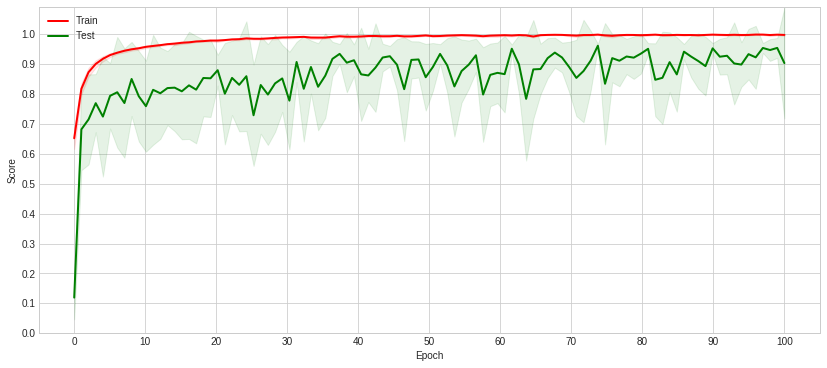

In [6]:
plot_mean_acc(hist)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

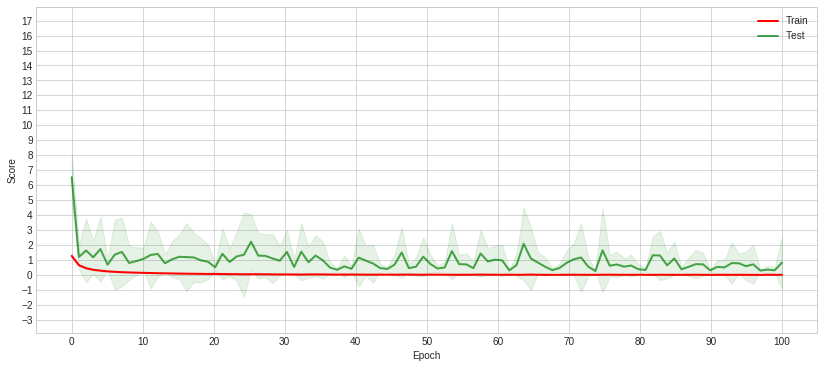

In [8]:
plot_mean_loss(hist)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

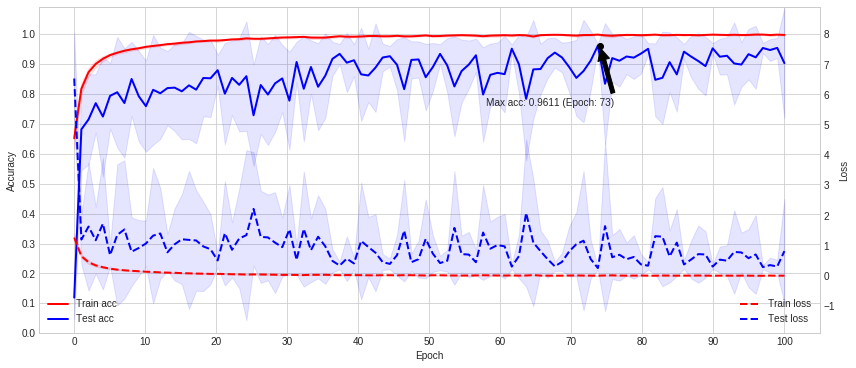

In [14]:
plot_mean(hist)